# Proyecto Equipo 10

## Integrantes del equipo:
- César García Gutiérrez
- Juan Rosendo González Feria
- Emilio Linarez Meneses
- Set Jafet Renedo Ortega

# Análisis de series de tiempo para activos financieros: estudio de relaciones entre distintos sectores de la Bolsa Mexicana de Valores
---


 

Para la realización de un portafolio de inversión óptimo, se debe minimizar el riesgo o varianza, después se maximiza el retorno, es decir, se filtran las empresas por mínima varianza y sobre esas empresas se seleccionan las empresas que mas utilidad genere, los modelos ARCH y GARCH son muy útiles para este tipo de análisis. 

Así mismo es bien sabido que los precios de algunas empresas están correlacionados, pues hemos seleccionado solo al mercado mexicano, el objetivo para un portafolio óptimo es que no exista relación alguna entre empresas o que tengan una relación negativa, pues si existiera una relación positiva entre ellas, si estas tuvieran una caída caería todo nuestro portafolio.

En el proyecto anterior nos concentramos en analizar 7 empresas de la Bolsa Mexicana de Valores a través de modelos ARCH y GARCH, dependiendo la estructura de los datos, los cuales nos indican si los precios de cierre y sus varianzas de días anteriores pueden explicar el precio de hoy de una acción, es decir un análisis de varianza de series de tiempo para las empresas de manera individual. 

En esta ocasión se realizará un análisis conjunto con la ayuda de un modelo de vectores auto regresivos (VAR), es decir, probaremos si los precios actuales y de días anteriores de todas las acciones afectan al precio actual de una acción, en otras palabras, veremos si las empresas se afectan entre ellas a través del tiempo, pues con este tipo de información, podríamos hacer una reformulación de un portafolio que nos resulte conveniente, dependiendo la relación que se encuentre entre ellas.


Comencemos instalando la librería *yfinance* pues Colab no la tiene por defecto:

In [ ]:
!pip install yfinance;

Ahora importamos todas las librerías necesarias para este trabajo:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import trim_mean

sns.set_style('darkgrid')

import yfinance as yf
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix

import plotly.express as px
!pip install plotly --upgrade

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


## Obtención de datos
Recordemos que de nuestro proyecto anterior se estuvo interesado en 7 empresas que cotizan en la BMV y que pertenecen a distintos sectores industriales del país. Las empresas y sus respectivos sectores son los siguientes:


|**Sector** | **Empresa** | 
|---|---|
|Industriales | Grupo Aeroportuario de México |
|Materiales | Cemex |
|Productos de consumo |	Walmart|
|Salud |	Corporativo Fragua |
|Financieros |	Grupo Financiero Banorte |
|Telecomunicaciones |	América Móvil |
|Productos de consumo no básicos |	Grupo Elektra|

Seguiremos trabajando con estos mismos sectores y con las mismas empresas, por lo que empecemos haciendo una solicitud a la API de *Yahoo Finance* para obtener los datos históricos de cada empresa


In [ ]:
gap = yf.Ticker('GAPB.MX').history(period = 'max')
cemex = yf.Ticker('CEMEXCPO.MX').history(period = 'max')
walmart = yf.Ticker('WMT.MX').history(period = 'max')
cfragua = yf.Ticker('FRAGUAB.MX').history(period = 'max')
banorte = yf.Ticker('GFNORTEO.MX').history(period = 'max')
amovil = yf.Ticker('AMXL.MX').history(period = 'max')
elektra = yf.Ticker('ELEKTRA.MX').history(period = 'max')


Ya obtenidos los dataframes veamos algunos datos de estos:

In [ ]:
gap.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2006-02-27,14.581499,15.060471,14.566685,14.912335,18404600.0,0.0,0
2006-02-28,14.813574,15.011088,14.319788,14.828388,9699400.0,0.0,0
2006-03-01,14.828386,15.653008,14.828386,15.391301,3748300.0,0.0,0
2006-03-02,15.544375,15.702386,15.430804,15.653008,3410700.0,0.0,0
2006-03-03,15.554250,15.707324,15.302420,15.391301,2939400.0,0.0,0


In [ ]:
cemex.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,6.600320,6.687330,6.401440,6.463591,8140433,0.0,0.0
2000-01-04,6.214989,6.239849,6.016109,6.016109,24190575,0.0,0.0
2000-01-05,6.022324,6.090689,5.891809,6.040969,36945498,0.0,0.0
2000-01-06,6.053399,6.096904,5.879380,5.941530,13890797,0.0,0.0
2000-01-07,5.966389,6.003679,5.916670,6.003679,43027159,0.0,0.0


In [ ]:
walmart.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-05-29,528.137315,529.496516,528.137315,528.321777,2370.0,0.0,0
2003-05-30,526.195374,526.195374,526.195374,526.195374,50.0,0.0,0
2003-06-02,527.079041,527.079041,527.079041,527.079041,75.0,0.0,0
2003-06-03,522.700684,522.700684,522.700684,522.700684,60.0,0.0,0
2003-06-04,542.408628,546.554077,542.408628,546.554077,14000.0,0.0,0


In [ ]:
cfragua.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-07,10.458428,10.458428,10.097793,10.097793,0,0.0,0
2000-01-10,10.097793,10.097793,10.097793,10.097793,0,0.0,0
2000-01-11,10.097793,10.097793,10.097793,10.097793,0,0.0,0
2000-01-12,10.169920,10.169920,10.097793,10.097793,0,0.0,0
2000-01-13,10.097793,10.097793,10.097793,10.097793,0,0.0,0


In [ ]:
banorte.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,2.586332,2.607590,2.426901,2.504845,2452000,0.0,0.0
2000-01-04,2.462331,2.462331,2.228498,2.249755,4920000,0.0,0.0
2000-01-05,2.249754,2.384385,2.178896,2.320613,2824000,0.0,0.0
2000-01-06,2.320613,2.356042,2.302899,2.356042,2116000,0.0,0.0
2000-01-07,2.359585,2.437529,2.359585,2.384385,4104000,0.0,0.0


In [ ]:
amovil.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-03-13,1.513513,1.513513,1.513513,1.513513,0,0.0,0.0
2000-03-14,1.513513,1.513513,1.513513,1.513513,0,0.0,0.0
2000-03-15,1.513513,1.513513,1.513513,1.513513,0,0.0,0.0
2000-03-16,1.513513,1.513513,1.513513,1.513513,0,0.0,0.0
2000-03-17,1.513513,1.513513,1.513513,1.513513,0,0.0,0.0


In [ ]:
elektra.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-12-25,33.906792,33.906792,33.906792,33.906792,0,0.0,0
2001-01-02,33.906801,33.906801,32.868837,33.041832,177000,0.0,0
2001-01-03,32.436343,34.425771,31.830864,34.339275,2815250,0.0,0
2001-01-04,35.031253,37.626161,35.031253,37.193676,3249200,0.0,0
2001-01-05,37.193681,37.193681,35.723232,35.723232,1377000,0.0,0


## Limpieza de datos y análisis de NaNs
Algo que podemos notar hasta aquí es que las fechas de los datos históricos de los precios NO empiezan en las mismas fechas. En el proyecto anterior ese no era un problema porque el análisis se hacía para cada serie de tiempo. En este caso haremos un análisis conjunto por lo que es necesario que todas nuestras series compartan las fechas. Busquemos entonces cual es la fecha mínima en la cual todas las empresas ya tienen datos. Para esto solo basta el primer dato de los dataframes de las empresas.  

In [ ]:
fechas = pd.DataFrame()
fechas['GAP'] = [gap.index[0]]
fechas['Cemex'] = cemex.index[0]
fechas['Walmart'] = walmart.index[0]
fechas['CFragua'] = cfragua.index[0]
fechas['Banorte'] = banorte.index[0]
fechas['AMovil'] = amovil.index[0]
fechas['Elektra'] = elektra.index[0]

fechas.head()

,GAP,Cemex,Walmart,CFragua,Banorte,AMovil,Elektra
0,2006-02-27,2000-01-03,2003-05-29,2000-01-07,2000-01-03,2000-03-13,2000-12-25


Observamos aquí que fue GAP la última empresa que empezó a cotizar en la bolsa, por lo tanto usaremos su fecha de inicio de cotización como punto de partida. Adicionalmente recordemos que solo estamos interesados en los precios de cierre de cada empresa, el cual corresponde a la columna *Close*

In [ ]:
precios = pd.DataFrame()
inicio = dt.datetime(2006, 2, 27)

precios['GAP'] = gap.loc[inicio :, 'Close']
precios['Cemex'] = cemex.loc[inicio :, 'Close']
precios['Walmart'] = walmart.loc[inicio :, 'Close']
precios['CFragua'] = cfragua.loc[inicio :, 'Close']
precios['Banorte'] = banorte.loc[inicio :, 'Close']
precios['AMovil'] = amovil.loc[inicio :, 'Close']
precios['Elektra'] = elektra.loc[inicio :, 'Close']

precios.head()

,GAP,Cemex,Walmart,CFragua,Banorte,AMovil,Elektra
Date,,,,,,,
2006-02-27,14.912335,21.463299,464.500763,13.986944,20.056293,6.261231,110.808929
2006-02-28,14.828388,21.089600,462.553192,13.986944,20.040640,6.261231,108.896194
2006-03-01,15.391301,21.356060,459.924072,13.986944,20.502337,6.261231,109.466347
2006-03-02,15.653008,21.222830,462.124878,13.986944,20.424080,6.261231,109.218040
2006-03-03,15.391301,21.408056,464.851349,13.986944,20.392778,6.261231,110.156006


¡Ya está listo nuestro dataframe!

Pero antes de empezar es necesario saber si existen datos faltantes en nuestro dataframe. Veamos si este es el caso:

In [ ]:
precios.isna().sum()

GAP         1
Cemex       0
Walmart    45
CFragua     5
Banorte    14
AMovil      0
Elektra     2
dtype: int64

Desgraciadamente en nuestro dataframe existen datos faltantes en algunas columnas, por lo que debemos pensar en la forma de lidiar con ellos. La opción natural a primera vista sería quitar los renglones con datos faltantes, sin embargo estamos trabajando con series de tiempo, por lo que esto no es una opción sensata. Lo que conviene hacer en estos casos es *imputar* los valores faltantes. Los métodos más populares en este tipo de series de tiempo, cuya naturaleza es fundamentalmente no lineal, son interpolación y *splines*. Nosotros usaremos *splines* para imputar los datos faltantes.  

In [ ]:
precios = precios.interpolate(method = 'spline', order = 3)
precios.isna().sum()

GAP        0
Cemex      0
Walmart    0
CFragua    0
Banorte    0
AMovil     0
Elektra    0
dtype: int64

¡Listo, nuestros NaN's se han ido!

## Primeras Gráficas
Ahora ya podemos hacer unas cuantas gráficas:


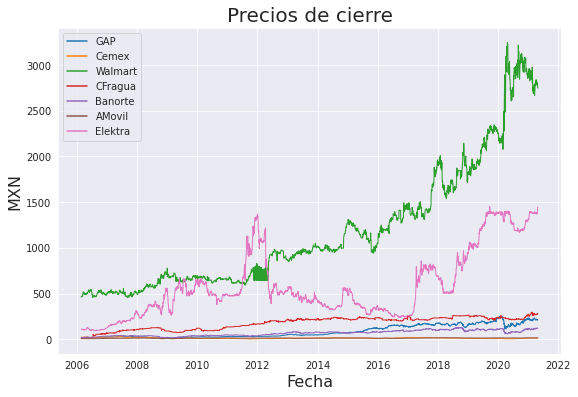

In [ ]:
plt.figure(figsize=(9,6))
plt.title('Precios de cierre', fontsize = 20)
plt.xlabel('Fecha', fontsize = 16)
plt.ylabel('MXN', fontsize = 16)
sns.lineplot(data = precios, dashes=False, lw = 1)
plt.show()

Malas noticias, Walmart tiene una región donde sus precios presentan una anomalía. Por el trabajo realizado al dataframe podemos darnos cuenta que este comportamiento NO se debe a la presencia de datos atípicos, sino que es inherente a la forma en la que han sido recopilados los datos.

Dado que esta región extraña aparece a principios del año 2012, conviene entonces excluirlos y tomar una fecha posterior. Por comodidad se seleccionó como nueva fecha de inicio el 1 de enero del 2013.

In [ ]:
inicio = dt.datetime(2013, 1, 1)

precios = precios.loc[inicio :, ]
precios.head()

,GAP,Cemex,Walmart,CFragua,Banorte,AMovil,Elektra
Date,,,,,,,
2013-01-02,51.752419,10.631586,869.669373,211.919342,72.875633,12.136619,527.324707
2013-01-03,50.943775,10.543456,868.235962,221.337967,71.699379,12.258718,525.782593
2013-01-04,50.229485,10.591528,868.235962,221.337967,70.413940,12.600594,527.933899
2013-01-07,49.178257,10.671644,860.476318,216.628632,71.422134,12.665712,532.826843
2013-01-08,48.976093,10.663632,860.476318,215.291199,71.993446,12.681993,571.332703


Ya podemos ver las series de tiempo ahora. Añadimos adicionalmente una gráfica en escala logaritmica para poder ver mejor las empresas cuyos precios sean los más pequeños.

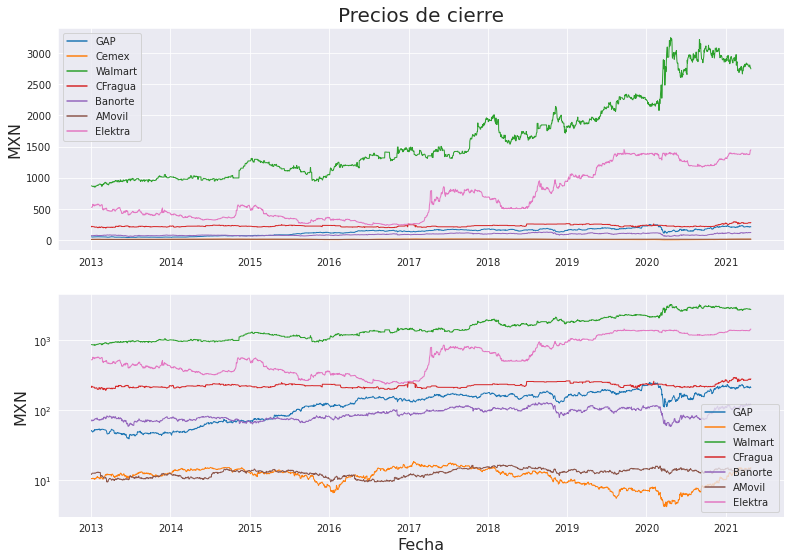

In [ ]:
plt.figure(figsize=(13,9))

plt.subplot(2,1 ,1)
plt.title('Precios de cierre', fontsize = 20)
plt.xlabel(' ')
plt.ylabel('MXN', fontsize = 16)
sns.lineplot(data = precios, dashes=False, lw = 1)

plt.subplot(2,1 ,2)
sns.lineplot(data = precios, dashes=False, lw = 1)
plt.xlabel('Fecha', fontsize = 16)
plt.ylabel('MXN', fontsize = 16)
plt.yscale('log')

plt.show()

¡Mucho mejor!

Hasta este momento hemos logrado obtener un dataframe sin valores nulos y sin regiones raras. Ya podemos empezar ahora.

## Modelo de Vectores Autoregresivos (VAR)



### Serie estacionaria: retornos porcentuales
El modelo de vectores autoregresivos requiere que las series de tiempo en cuestión sean estacionarias (i.e con media y varianza constante a lo largo del tiempo) cosa que claramente las series de tiempo de los precios de cierre no cumplen. Sin embargo ya nos hemos topado con series estacionarias en el proyecto anterior: las series de retornos porcentuales (y las de los log-retornos) cumplen este requisito.

In [ ]:
ret_pct = precios.pct_change()
ret_pct = ret_pct.dropna(axis = 0)
ret_pct = ret_pct * 100
ret_pct.head()

,GAP,Cemex,Walmart,CFragua,Banorte,AMovil,Elektra
Date,,,,,,,
2013-01-03,-1.562523,-0.828945,-0.164822,4.444439,-1.614057,1.006037,-0.292441
2013-01-04,-1.402116,0.455940,0.000000,0.000000,-1.792817,2.788840,0.409163
2013-01-07,-2.092850,0.756418,-0.893725,-2.127667,1.431810,0.516791,0.926810
2013-01-08,-0.411083,-0.075076,0.000000,-0.617385,0.799909,0.128537,7.226712
2013-01-09,1.513499,0.976709,0.229762,-0.253747,1.470414,-0.385110,0.588160


Una forma de verificar que las series de retornos porcentueles realmente son series estacionarias es usando una **prueba de hipótesis**, especialmente la prueba de *Dickey-Fuller* aumentada. Esta prueba, en resumen, tiene las siguientes hipótesis:

* $H_0$: la serie de tiempo no es estacionaria.
* $H_1$: la serie de tiempo es estacionaria.

Estas hipótesis se traducen en que si se obtiene un *p-value* menor a $\alpha=0.05$ podremos asegurar que nuestras series de tiempo son estacionarias.

Empecemos creando una función para poder presentar adecuadamente los resultados de esta prueba: 

In [ ]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

Ahora si veamos los resultados de la prueba de *Dickey-Fuller* aumentada para nuestra primera serie de tiempo, la cual corresponde a la empresa Grupo Aeroportuario del Pacífico: 

In [ ]:
adf_test(ret_pct['GAP'])

Results of Dickey-Fuller Test:
Test Statistic                -1.436949e+01
p-value                        9.547509e-27
#Lags Used                     9.000000e+00
Number of Observations Used    2.074000e+03
Critical Value (1%)           -3.433507e+00
Critical Value (5%)           -2.862935e+00
Critical Value (10%)          -2.567512e+00
dtype: float64


Se puede observar que el valor del estadístico de prueba tiene un valor negativo tan grande lo que se traduce como un p-valor más pequeño que nuestra $\alpha=0.05$ por lo que podemos concluir que esta serie es estacionaria.

Veamos ahora a la empresa Cemex

In [ ]:
adf_test(ret_pct['Cemex'])

Results of Dickey-Fuller Test:
Test Statistic                -1.692182e+01
p-value                        9.926730e-30
#Lags Used                     6.000000e+00
Number of Observations Used    2.077000e+03
Critical Value (1%)           -3.433502e+00
Critical Value (5%)           -2.862933e+00
Critical Value (10%)          -2.567511e+00
dtype: float64


En este caso observamos nuevamente un p-valor muy pequeño, máás pequeño que nuestro valor de $\alpha$. Por lo tanto esta serie es estacionaria también.

La siguiente serie de tiempo corresponde a la empresa Walmart:

In [ ]:
adf_test(ret_pct['Walmart'])

Results of Dickey-Fuller Test:
Test Statistic                -1.539737e+01
p-value                        3.249382e-28
#Lags Used                     8.000000e+00
Number of Observations Used    2.075000e+03
Critical Value (1%)           -3.433505e+00
Critical Value (5%)           -2.862934e+00
Critical Value (10%)          -2.567512e+00
dtype: float64


¡Esta serie es estacionaria también!

La siguiente serie a analizar es la correspondiente a la empresa Corporativo Fragua:

In [ ]:
adf_test(ret_pct['CFragua'])

Results of Dickey-Fuller Test:
Test Statistic                -1.438369e+01
p-value                        9.063771e-27
#Lags Used                     1.000000e+01
Number of Observations Used    2.073000e+03
Critical Value (1%)           -3.433508e+00
Critical Value (5%)           -2.862935e+00
Critical Value (10%)          -2.567513e+00
dtype: float64


La serie es estacionaria.

Veamos la siguiente serie, la cual corresponde a la empresa Grupo Financiero Banorte:

In [ ]:
adf_test(ret_pct['Banorte'])

Results of Dickey-Fuller Test:
Test Statistic                -1.761714e+01
p-value                        3.854388e-30
#Lags Used                     6.000000e+00
Number of Observations Used    2.077000e+03
Critical Value (1%)           -3.433502e+00
Critical Value (5%)           -2.862933e+00
Critical Value (10%)          -2.567511e+00
dtype: float64


La serie es estacionaria.

La siguiente empresa a estudiar es América Móvil:

In [ ]:
adf_test(ret_pct['AMovil'])

Results of Dickey-Fuller Test:
Test Statistic                  -20.405901
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    2077.000000
Critical Value (1%)              -3.433502
Critical Value (5%)              -2.862933
Critical Value (10%)             -2.567511
dtype: float64


El p-valor obtenido es nulo, por lo que la serie es estacionaria.

Finalmente veamos a la empresa Grupo Elektra:

In [ ]:
adf_test(ret_pct['Elektra'])

Results of Dickey-Fuller Test:
Test Statistic                -7.272380e+00
p-value                        1.576098e-10
#Lags Used                     2.100000e+01
Number of Observations Used    2.062000e+03
Critical Value (1%)           -3.433525e+00
Critical Value (5%)           -2.862943e+00
Critical Value (10%)          -2.567517e+00
dtype: float64


¡Listo!

Hemos probado que **todas las series de tiempo que utilizaremos son series estacionaria**.

### Estimados de locación y variabilidad

Una vez confirmada la utilidad del dataframe `ret_pct` creado es bueno cerciorarse del tipo de datos que contiene y ademas obtener algunas estadísticas de interés sobre las variables del dataframe:

In [ ]:
ret_pct.dtypes

GAP        float64
Cemex      float64
Walmart    float64
CFragua    float64
Banorte    float64
AMovil     float64
Elektra    float64
dtype: object

In [ ]:
stats = ret_pct.describe()

dicc = {'count': 'Conteo',
        'mean': 'Promedio',
        'std' : 'Desviación estándar',
        '50%' : 'Mediana',
        'min' : 'Mínimo',
        'max' : 'Máximo'}

stats = stats.rename(index = dicc)
stats = stats.append(pd.Series(stats.loc['Máximo', :] - stats.loc['Mínimo', :], name = 'Rango'))
stats = stats.append(pd.Series(stats.loc['75%', :] - stats.loc['25%', :], name = 'IQR'))
stats = stats.append(pd.Series([trim_mean(ret_pct[i], 0.1) for i in ret_pct.columns], name = 'Media Truncada (0.1)', index = ret_pct.columns))
stats.round(3)

,GAP,Cemex,Walmart,CFragua,Banorte,AMovil,Elektra
Conteo,2084.000,2084.000,2084.000,2084.000,2084.000,2084.000,2084.000
Promedio,0.087,0.042,0.067,0.021,0.045,0.022,0.066
Desviación estándar,1.934,2.230,1.528,1.251,2.024,1.595,1.890
Mínimo,-17.380,-9.135,-9.465,-10.200,-13.454,-11.217,-24.016
25%,-0.881,-1.157,-0.359,0.000,-0.991,-0.876,-0.752
Mediana,0.060,0.000,0.000,0.000,0.084,0.000,-0.050
75%,1.010,1.149,0.439,0.000,1.102,0.897,0.693
Máximo,13.900,13.594,14.958,11.711,10.414,11.549,14.294
Rango,31.280,22.729,24.423,21.911,23.868,22.766,38.311
IQR,1.891,2.306,0.798,0.000,2.093,1.773,1.446


### Visualización de datos: Segundas Gráficas

 

#### GAP
Veamos ahora algunas gráficas de nuestro dataset. Empecemos con el Grupo Aeroportuario del Pacífico:

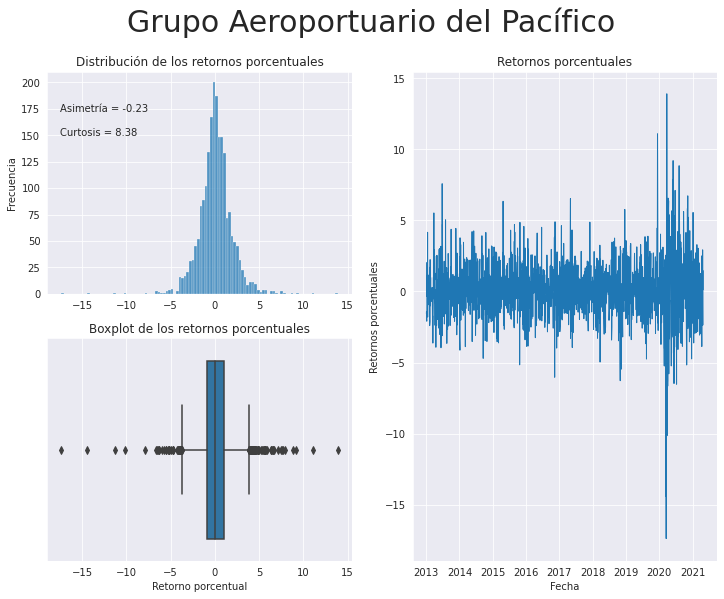

In [ ]:
plt.figure(figsize=(12,9))

plt.subplot(2, 2, 1)
sns.histplot(x = ret_pct['GAP'])
plt.title('Distribución de los retornos porcentuales')
plt.ylabel('Frecuencia')
plt.xlabel(' ')
plt.text(-17.5, 150, f'''Asimetría = {ret_pct['GAP'].skew().round(2)}

Curtosis = {ret_pct['GAP'].kurtosis().round(2)}''')

plt.subplot(2, 2, (2, 4))
sns.lineplot(x = ret_pct.index, y = ret_pct['GAP'], dashes=False, lw = 1)
plt.title('Retornos porcentuales')
plt.ylabel('Retornos porcentuales')
plt.xlabel('Fecha')

plt.subplot(2, 2, 3)
sns.boxplot(x = ret_pct['GAP'])
plt.title('Boxplot de los retornos porcentuales')
plt.xlabel('Retorno porcentual', fontsize = 10)
plt.ylabel(' ')

plt.suptitle('Grupo Aeroportuario del Pacífico', fontsize = 30)
plt.show()

Podemos observar que la distribución de los retornos porcentuales se parece a una distribución normal, sin embargo presenta valores atípicos lo cual se traduce en un valor alto de curtosis. En general la distribución de los retornos de series de activos financieros es una distribución con colas pesadas (tipo distribución *t* de *Student*). Por último, podemos ver que la serie de tiempo de la empresa no presenta tendencia ni variabilidad de los datos lo cual confirma la estacionariedad anteriormente probada con la prueba de *Dickey-Fuller* aumentada. Dado que todas las empresas presentan series de tiempo estacionarias podemos predecir que estas tendrán una forma similar.

#### Cemex

Ahora veamos las mismas gráficas para la empresa Cemex:

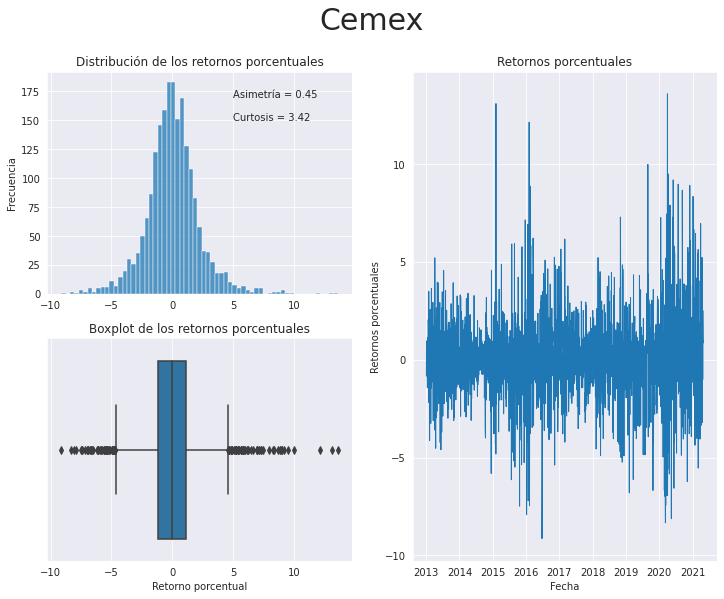

In [ ]:
plt.figure(figsize=(12,9))

plt.subplot(2, 2, 1)
sns.histplot(x = ret_pct['Cemex'])
plt.title('Distribución de los retornos porcentuales')
plt.ylabel('Frecuencia')
plt.xlabel(' ')
plt.text(5, 150, f'''Asimetría = {ret_pct['Cemex'].skew().round(2)}

Curtosis = {ret_pct['Cemex'].kurtosis().round(2)}''')

plt.subplot(2, 2, (2, 4))
sns.lineplot(x = ret_pct.index, y = ret_pct['Cemex'], dashes=False, lw = 1)
plt.title('Retornos porcentuales')
plt.ylabel('Retornos porcentuales')
plt.xlabel('Fecha')

plt.subplot(2, 2, 3)
sns.boxplot(x = ret_pct['Cemex'])
plt.title('Boxplot de los retornos porcentuales')
plt.xlabel('Retorno porcentual', fontsize = 10)
plt.ylabel(' ')

plt.suptitle('Cemex', fontsize = 30)
plt.show()

Nuevamente se tiene una distribución simétrica de colas pesadas y una serie de tiempo sin tendencia y con poca variabilidad.

#### Walmart

Veamos los gráficos de Walmart:

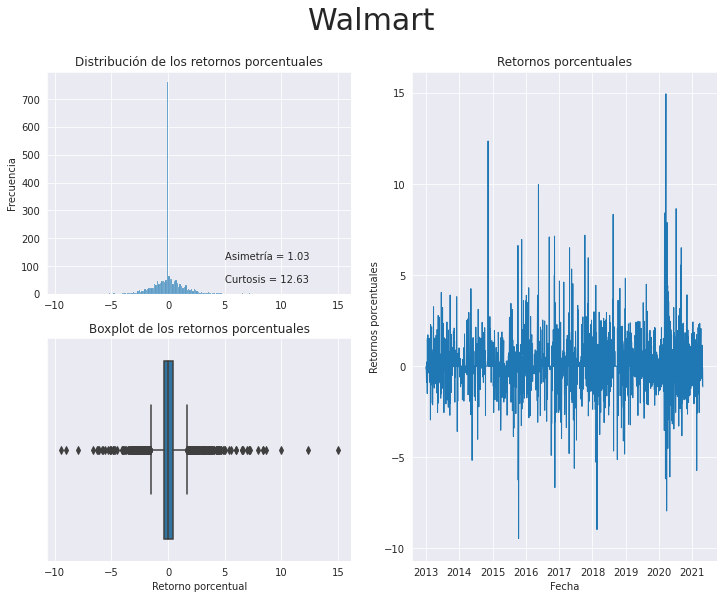

In [ ]:
plt.figure(figsize=(12,9))

plt.subplot(2, 2, 1)
sns.histplot(x = ret_pct['Walmart'])
plt.title('Distribución de los retornos porcentuales')
plt.ylabel('Frecuencia')
plt.xlabel(' ')
#plt.ylim((0, 60))
plt.text(5, 40, f'''Asimetría = {ret_pct['Walmart'].skew().round(2)}

Curtosis = {ret_pct['Walmart'].kurtosis().round(2)}''')

plt.subplot(2, 2, (2, 4))
sns.lineplot(x = ret_pct.index, y = ret_pct['Walmart'], dashes=False, lw = 1)
plt.title('Retornos porcentuales')
plt.ylabel('Retornos porcentuales')
plt.xlabel('Fecha')

plt.subplot(2, 2, 3)
sns.boxplot(x = ret_pct['Walmart'])
plt.title('Boxplot de los retornos porcentuales')
plt.xlabel('Retorno porcentual', fontsize = 10)
plt.ylabel(' ')

plt.suptitle('Walmart', fontsize = 30)
plt.show()

Podemos ver que la distribución de los retornos vuelve a ser simétrica de colas pesadas sin embargo tiene un valor cercano a 0 que se repite demasiadas veces. Una vez más la serie de tiempo no tiene tendencia y presenta poca variabilidad.

#### Corportivo Fragua

Veamos ahora las gráficas del Corporativo Fragua:

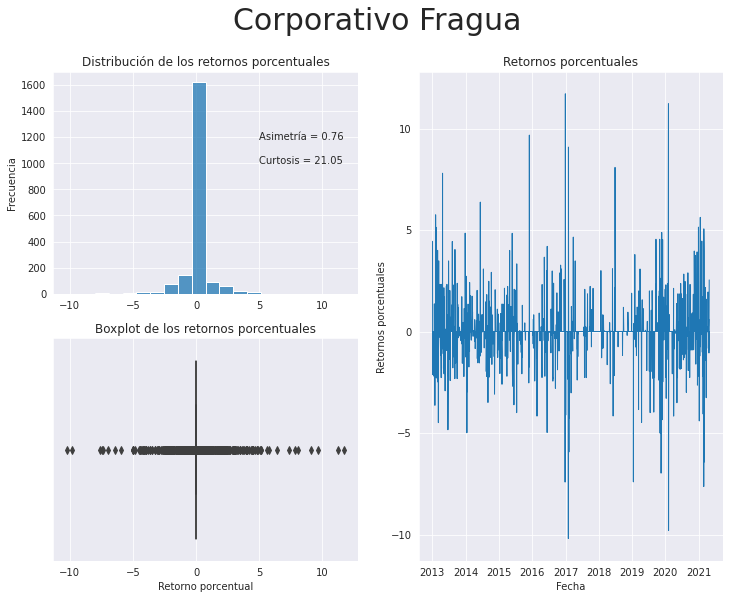

In [ ]:
plt.figure(figsize=(12,9))

plt.subplot(2, 2, 1)
sns.histplot(x = ret_pct['CFragua'], bins = 20)
plt.title('Distribución de los retornos porcentuales')
plt.ylabel('Frecuencia')
plt.xlabel(' ')
plt.text(5, 1000, f'''Asimetría = {ret_pct['CFragua'].skew().round(2)}

Curtosis = {ret_pct['CFragua'].kurtosis().round(2)}''')

plt.subplot(2, 2, (2, 4))
sns.lineplot(x = ret_pct.index, y = ret_pct['CFragua'], dashes=False, lw = 1)
plt.title('Retornos porcentuales')
plt.ylabel('Retornos porcentuales')
plt.xlabel('Fecha')

plt.subplot(2, 2, 3)
sns.boxplot(x = ret_pct['CFragua'])
plt.title('Boxplot de los retornos porcentuales')
plt.xlabel('Retorno porcentual', fontsize = 10)
plt.ylabel(' ')

plt.suptitle('Corporativo Fragua', fontsize = 30)
plt.show()

En este caso podemos notar un alto valor de curtosis, además de que el boxplot muestra que más del 75% de los datos se concentran en valores cercanos a 0. Este comportamiento se debe principalmente a que esta empresa tiende a tener valores constantes en el precio de sus acciones, lo cual se puede observar en las gráficas de las series de tiempo.

#### Grupo Financiero Banorte

Veamos ahora al Grupo Financiero Banorte:

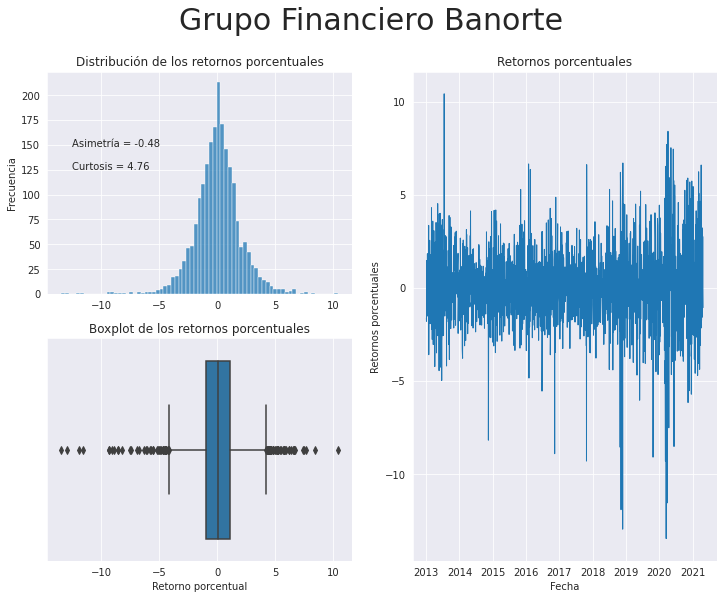

In [ ]:
plt.figure(figsize=(12,9))

plt.subplot(2, 2, 1)
sns.histplot(x = ret_pct['Banorte'])
plt.title('Distribución de los retornos porcentuales')
plt.ylabel('Frecuencia')
plt.xlabel(' ')
plt.text(-12.5, 125, f'''Asimetría = {ret_pct['Banorte'].skew().round(2)}

Curtosis = {ret_pct['Banorte'].kurtosis().round(2)}''')

plt.subplot(2, 2, (2, 4))
sns.lineplot(x = ret_pct.index, y = ret_pct['Banorte'], dashes=False, lw = 1)
plt.title('Retornos porcentuales')
plt.ylabel('Retornos porcentuales')
plt.xlabel('Fecha')

plt.subplot(2, 2, 3)
sns.boxplot(x = ret_pct['Banorte'])
plt.title('Boxplot de los retornos porcentuales')
plt.xlabel('Retorno porcentual', fontsize = 10)
plt.ylabel(' ')

plt.suptitle('Grupo Financiero Banorte', fontsize = 30)
plt.show()

Podemos observar nuevamente una distribución simétrica de colas pesadas.

#### América Móvil

Veamos a la empresa América Móvil:

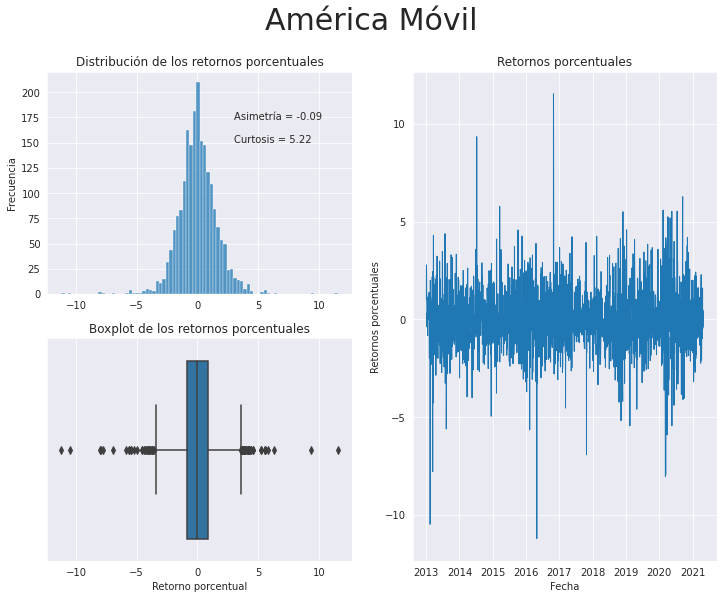

In [ ]:
plt.figure(figsize=(12,9))

plt.subplot(2, 2, 1)
sns.histplot(x = ret_pct['AMovil'])
plt.title('Distribución de los retornos porcentuales')
plt.ylabel('Frecuencia')
plt.xlabel(' ')
plt.text(3, 150, f'''Asimetría = {ret_pct['AMovil'].skew().round(2)}

Curtosis = {ret_pct['AMovil'].kurtosis().round(2)}''')

plt.subplot(2, 2, (2, 4))
sns.lineplot(x = ret_pct.index, y = ret_pct['AMovil'], dashes=False, lw = 1)
plt.title('Retornos porcentuales')
plt.ylabel('Retornos porcentuales')
plt.xlabel('Fecha')

plt.subplot(2, 2, 3)
sns.boxplot(x = ret_pct['AMovil'])
plt.title('Boxplot de los retornos porcentuales')
plt.xlabel('Retorno porcentual', fontsize = 10)
plt.ylabel(' ')

plt.suptitle('América Móvil', fontsize = 30)
plt.show()

Una vez más vemos colas pesadas con respecto a una disribución normal.

#### Grupo Elektra

Finalmente veamos algunas gráficas del Grupo Elektra:

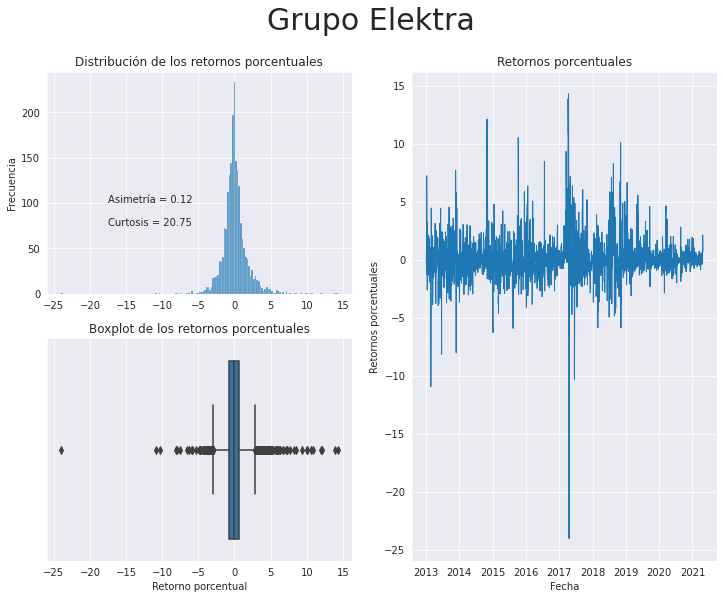

In [ ]:
plt.figure(figsize=(12,9))

plt.subplot(2, 2, 1)
sns.histplot(x = ret_pct['Elektra'])
plt.title('Distribución de los retornos porcentuales')
plt.ylabel('Frecuencia')
plt.xlabel(' ')
plt.text(-17.5, 75, f'''Asimetría = {ret_pct['Elektra'].skew().round(2)}

Curtosis = {ret_pct['Elektra'].kurtosis().round(2)}''')

plt.subplot(2, 2, (2, 4))
sns.lineplot(x = ret_pct.index, y = ret_pct['Elektra'], dashes=False, lw = 1)
plt.title('Retornos porcentuales')
plt.ylabel('Retornos porcentuales')
plt.xlabel('Fecha')

plt.subplot(2, 2, 3)
sns.boxplot(x = ret_pct['Elektra'])
plt.title('Boxplot de los retornos porcentuales')
plt.xlabel('Retorno porcentual', fontsize = 10)
plt.ylabel(' ')

plt.suptitle('Grupo Elektra', fontsize = 30)
plt.show()

Observamos nuevamente colas pesadas, además de un outlier bastante notable con un valor cercano a 25 el cual se puede ver que se debe a que entre 2017 y 2018 la empresa aumentó su precio abruptamente.

Es notable destacar que en este trabajo la presencia de valores atípicos es evidente y se presenta en cada una de las series de tiempo a estudiar, sin embargo NO podemos desechar dichos valores debido a la estructura temporal de los datos y además de que es justo la presencia de valores atípicos lo que caracteriza a estas series de tiempo de activos financieros.

### Obtención de variables categóricas

Para poder obtener variables categóricas de nuestras series de tiempo podemos usar dos categorias que hagan referencia a si sube o baja el precio de la acción con respecto al día anterior. Así tendremos un *Down* en un día si el precio de dicho día es menor que el día anterior y *Up* en caso contrario.

Una forma de poder clasificar nuestros precios es a través de sus diferencias, pues si la diferencia de un día resulta ser positiva eso quiere decir que ha habido un aumento con respecto al día anterior. Contrariamente si la diferencia es negativa, entonces el precio actual es menor al anterior.

Con esto en mente vamos a crear un dataframe con las diferencias.

In [ ]:
aux = precios.diff().dropna()
aux.head()

,GAP,Cemex,Walmart,CFragua,Banorte,AMovil,Elektra
Date,,,,,,,
2013-01-03,-0.808643,-0.088130,-1.433411,9.418625,-1.176254,0.122099,-1.542114
2013-01-04,-0.714291,0.048072,0.000000,0.000000,-1.285439,0.341876,2.151306
2013-01-07,-1.051228,0.080116,-7.759644,-4.709335,1.008194,0.065119,4.892944
2013-01-08,-0.202164,-0.008012,0.000000,-1.337433,0.571312,0.016280,38.505859
2013-01-09,0.741253,0.104153,1.977051,-0.546295,1.058601,-0.048840,3.360352


Para mapear estos valores a *Down* o a *Up* basta saber su signo, para ello podemos hacer una función que nos ayude a clasificar:

In [ ]:
def cats(Serie):
    aux = []
    for i in Serie:
        if i < 0:
            aux.append('Down')
        else:
            aux.append('Up')
    return aux

Ya con esto podemos armar un nuevo dataframe con estas categorías:

In [ ]:
up_down = pd.DataFrame()
up_down['GAP cambio'] = pd.Series(cats(aux['GAP']), dtype = 'category', index=aux.index)
up_down['Cemex cambio'] = pd.Series(cats(aux['Cemex']), dtype = 'category', index=aux.index)
up_down['Walmart cambio'] = pd.Series(cats(aux['Walmart']), dtype = 'category', index=aux.index)
up_down['CFragua cambio'] = pd.Series(cats(aux['CFragua']), dtype = 'category', index=aux.index)
up_down['Banorte cambio'] = pd.Series(cats(aux['Banorte']), dtype = 'category', index=aux.index)
up_down['AMovil cambio'] = pd.Series(cats(aux['AMovil']), dtype = 'category', index=aux.index)
up_down['Elektra cambio'] = pd.Series(cats(aux['Elektra']), dtype = 'category', index=aux.index)
up_down.head()

,GAP cambio,Cemex cambio,Walmart cambio,CFragua cambio,Banorte cambio,AMovil cambio,Elektra cambio
Date,,,,,,,
2013-01-03,Down,Down,Down,Up,Down,Up,Down
2013-01-04,Down,Up,Up,Up,Down,Up,Up
2013-01-07,Down,Up,Down,Down,Up,Up,Up
2013-01-08,Down,Down,Up,Down,Up,Up,Up
2013-01-09,Up,Up,Up,Down,Up,Down,Up


Podemos combinar este dataframe con el de los retornos porcentuales para así obtener un dataframe con variables numéricas y variables categóricas:

In [ ]:
final = ret_pct.copy()
final['GAP cambio'] = up_down['GAP cambio']
final['Cemex cambio'] = up_down['Cemex cambio']
final['Walmart cambio'] = up_down['Walmart cambio']
final['CFragua cambio'] = up_down['CFragua cambio']
final['Banorte cambio'] = up_down['Banorte cambio']
final['AMovil cambio'] = up_down['AMovil cambio']
final['Elektra cambio'] = up_down['Elektra cambio']
final.head()

,GAP,Cemex,Walmart,CFragua,Banorte,AMovil,Elektra,GAP cambio,Cemex cambio,Walmart cambio,CFragua cambio,Banorte cambio,AMovil cambio,Elektra cambio
Date,,,,,,,,,,,,,,
2013-01-03,-1.562523,-0.828945,-0.164822,4.444439,-1.614057,1.006037,-0.292441,Down,Down,Down,Up,Down,Up,Down
2013-01-04,-1.402116,0.455940,0.000000,0.000000,-1.792817,2.788840,0.409163,Down,Up,Up,Up,Down,Up,Up
2013-01-07,-2.092850,0.756418,-0.893725,-2.127667,1.431810,0.516791,0.926810,Down,Up,Down,Down,Up,Up,Up
2013-01-08,-0.411083,-0.075076,0.000000,-0.617385,0.799909,0.128537,7.226712,Down,Down,Up,Down,Up,Up,Up
2013-01-09,1.513499,0.976709,0.229762,-0.253747,1.470414,-0.385110,0.588160,Up,Up,Up,Down,Up,Down,Up


Reordenemos las columnas para que cada empresa tenga a su lado el cambio con respecto al día anterior:

In [ ]:
final = final.reindex(columns = ['GAP', 'GAP cambio', 'Cemex', 'Cemex cambio', 'Walmart', 'Walmart cambio', 'CFragua', 'CFragua cambio', 'Banorte', 'Banorte cambio', 'AMovil', 'AMovil cambio', 'Elektra', 'Elektra cambio'])
final.head()

,GAP,GAP cambio,Cemex,Cemex cambio,Walmart,Walmart cambio,CFragua,CFragua cambio,Banorte,Banorte cambio,AMovil,AMovil cambio,Elektra,Elektra cambio
Date,,,,,,,,,,,,,,
2013-01-03,-1.562523,Down,-0.828945,Down,-0.164822,Down,4.444439,Up,-1.614057,Down,1.006037,Up,-0.292441,Down
2013-01-04,-1.402116,Down,0.455940,Up,0.000000,Up,0.000000,Up,-1.792817,Down,2.788840,Up,0.409163,Up
2013-01-07,-2.092850,Down,0.756418,Up,-0.893725,Down,-2.127667,Down,1.431810,Up,0.516791,Up,0.926810,Up
2013-01-08,-0.411083,Down,-0.075076,Down,0.000000,Up,-0.617385,Down,0.799909,Up,0.128537,Up,7.226712,Up
2013-01-09,1.513499,Up,0.976709,Up,0.229762,Up,-0.253747,Down,1.470414,Up,-0.385110,Down,0.588160,Up


¡Muchisimo mejor!

### Visualización de datos categóricos


Ahora si podemos ver las categorias en un gráfico de barras y además ver los valores de retorno condicionados a cada categoría:

#### GAP

Comencemos el Grupo Aeroportuario del Pacífico:

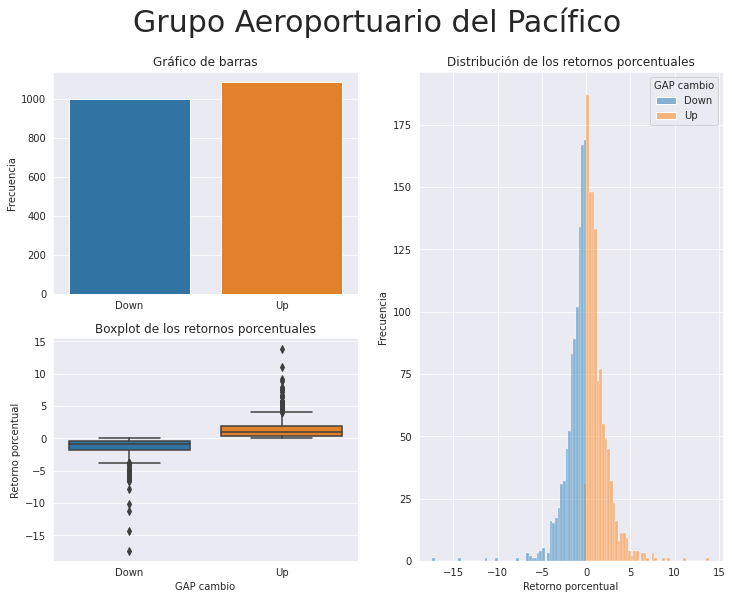

In [ ]:
aux = final.groupby('GAP cambio')['GAP'].count()

plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
sns.barplot(x = aux.index, y = aux)
plt.xlabel('')
plt.ylabel('Frecuencia')
plt.title('Gráfico de barras')

plt.subplot(2, 2, (2, 4))
sns.histplot(x = final['GAP'], hue = final['GAP cambio'])
plt.xlabel('Retorno porcentual')
plt.ylabel('Frecuencia')
plt.title('Distribución de los retornos porcentuales')

plt.subplot(2, 2, 3)
sns.boxplot(x = final['GAP cambio'], y = final['GAP'])
plt.ylabel('Retorno porcentual')
plt.title('Boxplot de los retornos porcentuales')

plt.suptitle('Grupo Aeroportuario del Pacífico', fontsize = 30)

plt.show()

Esta categorización de nuestros datos nos permiten decir bastantes cosas, entre las cuales vale la pena remarcar algunas:

- La naturaleza simétrica de la distribución de los retornos porcentuales está asociada al equilibrio entre las subidas y bajadas de precios de las acciones.
- La presencia de outliers se da en ambos casos: cuando la acción tiende a subir y cuando tiende a bajar.

Estas características se verán reflejadas también en los gráficos de las otras empresas, veamoslo:

#### Cemex

La siguente empresa es Cemex:

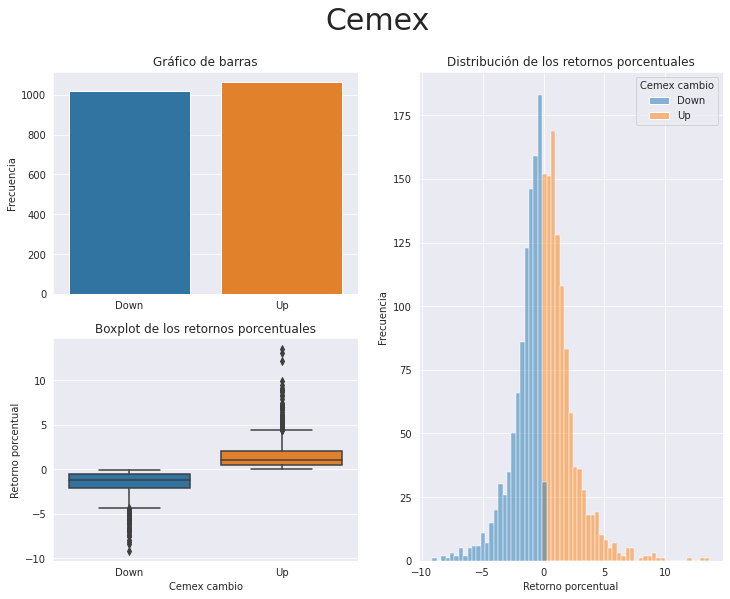

In [ ]:
aux = final.groupby('Cemex cambio')['Cemex'].count()

plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
sns.barplot(x = aux.index, y = aux)
plt.xlabel('')
plt.ylabel('Frecuencia')
plt.title('Gráfico de barras')

plt.subplot(2, 2, (2, 4))
sns.histplot(x = final['Cemex'], hue = final['Cemex cambio'])
plt.xlabel('Retorno porcentual')
plt.ylabel('Frecuencia')
plt.title('Distribución de los retornos porcentuales')

plt.subplot(2, 2, 3)
sns.boxplot(x = final['Cemex cambio'], y = final['Cemex'])
plt.ylabel('Retorno porcentual')
plt.title('Boxplot de los retornos porcentuales')

plt.suptitle('Cemex', fontsize = 30)

plt.show()

Observamos nuevamente outliers de ambos lados y un conteo casi igual entre subidas y bajadas de los precios. Todo esto explica la naturaleza simétrica y de colas pesadas de la distribución.

#### Walmart
Veamos ahora a la empresa Walmart:

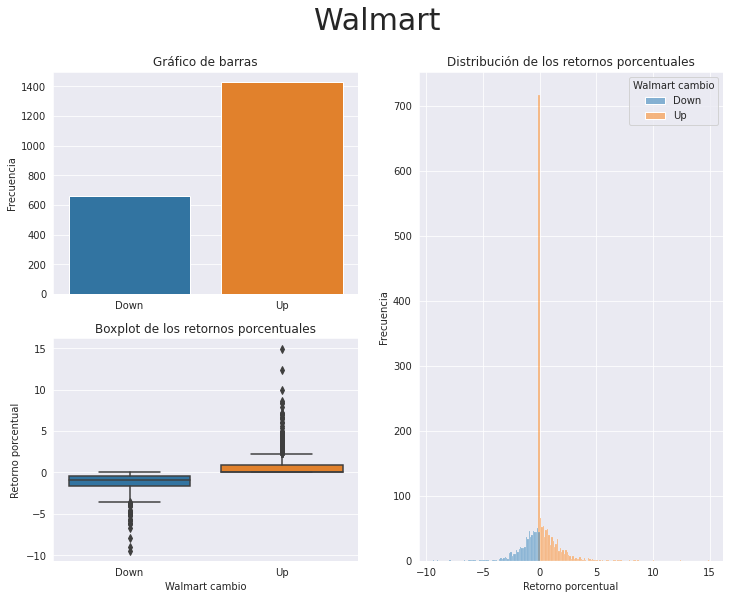

In [ ]:
aux = final.groupby('Walmart cambio')['Walmart'].count()

plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
sns.barplot(x = aux.index, y = aux)
plt.xlabel('')
plt.ylabel('Frecuencia')
plt.title('Gráfico de barras')

plt.subplot(2, 2, (2, 4))
sns.histplot(x = final['Walmart'], hue = final['Walmart cambio'])
plt.xlabel('Retorno porcentual')
plt.ylabel('Frecuencia')
plt.title('Distribución de los retornos porcentuales')

plt.subplot(2, 2, 3)
sns.boxplot(x = final['Walmart cambio'], y = final['Walmart'])
plt.ylabel('Retorno porcentual')
plt.title('Boxplot de los retornos porcentuales')

plt.suptitle('Walmart', fontsize = 30)

plt.show()

Dada esta categorización de los datos ya podemos explicar el porqué del dato cercano a 0 que se repite demasiado en el histograma. Podemos ver que el número de veces que el precio de la empresa subió sobrepasa demasiado al número de veces que bajó. Esto se ve claramente en la serie de tiempo del precio de la empresa pues se tiene una tendencia alcista.


#### Corporativo Fragua

Veamos la siguiente empresa:

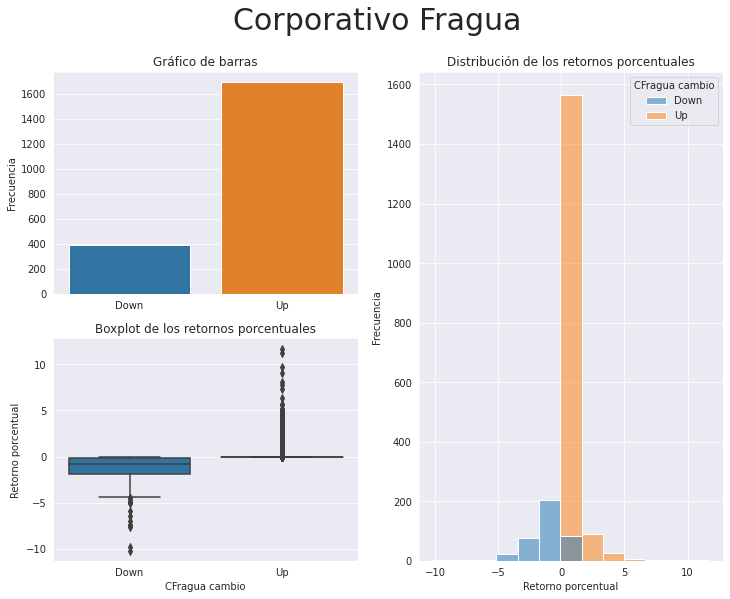

In [ ]:
aux = final.groupby('CFragua cambio')['CFragua'].count()

plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
sns.barplot(x = aux.index, y = aux)
plt.xlabel('')
plt.ylabel('Frecuencia')
plt.title('Gráfico de barras')

plt.subplot(2, 2, (2, 4))
sns.histplot(x = final['CFragua'], hue = final['CFragua cambio'])
plt.xlabel('Retorno porcentual')
plt.ylabel('Frecuencia')
plt.title('Distribución de los retornos porcentuales')

plt.subplot(2, 2, 3)
sns.boxplot(x = final['CFragua cambio'], y = final['CFragua'])
plt.ylabel('Retorno porcentual')
plt.title('Boxplot de los retornos porcentuales')

plt.suptitle('Corporativo Fragua', fontsize = 30)

plt.show()

Analogo a la empresa anterior podemos ver aquí también parte de la explicación de la forma irregular del histograma: la empresa ha tenido más periodos en los que su valor es mayor al anterior y se remarca en la asimetría de la distribución. Por otra parte, mas del 75% de los datos en la categoría *Up* están acumulados cerca del 0.

#### Grupo Financiero Banorte

Para la siguiente empresa tenemos los gráficos siguientes:

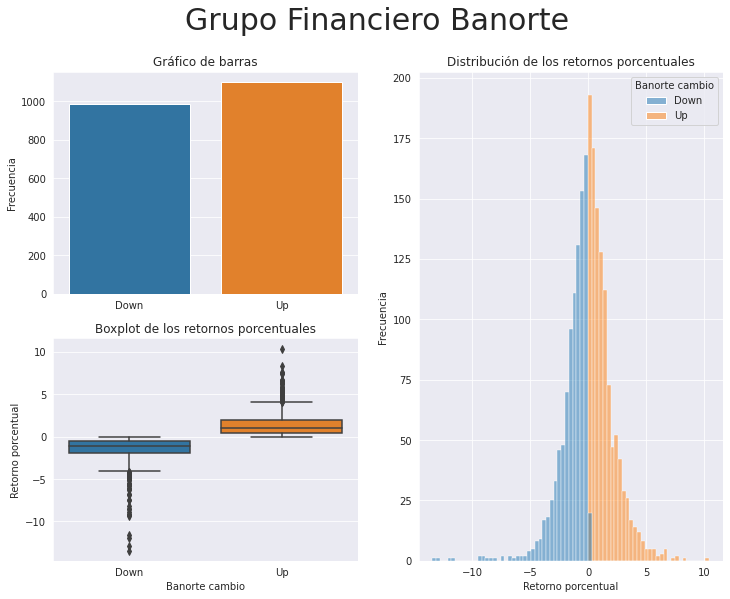

In [ ]:
aux = final.groupby('Banorte cambio')['Banorte'].count()

plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
sns.barplot(x = aux.index, y = aux)
plt.xlabel('')
plt.ylabel('Frecuencia')
plt.title('Gráfico de barras')

plt.subplot(2, 2, (2, 4))
sns.histplot(x = final['Banorte'], hue = final['Banorte cambio'])
plt.xlabel('Retorno porcentual')
plt.ylabel('Frecuencia')
plt.title('Distribución de los retornos porcentuales')

plt.subplot(2, 2, 3)
sns.boxplot(x = final['Banorte cambio'], y = final['Banorte'])
plt.ylabel('Retorno porcentual')
plt.title('Boxplot de los retornos porcentuales')

plt.suptitle('Grupo Financiero Banorte', fontsize = 30)

plt.show()

Para esta empresa nuevamente observamos esa simetría en las categorías y la existencia de outliers en ambas.

#### América Móvil
Veamos ahora los gráficos de la empresa América Móvil:

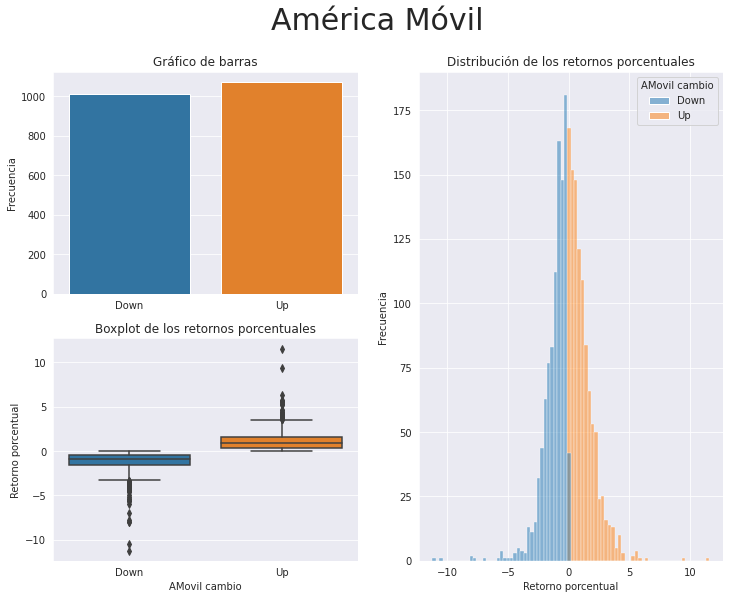

In [ ]:
aux = final.groupby('AMovil cambio')['AMovil'].count()

plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
sns.barplot(x = aux.index, y = aux)
plt.xlabel('')
plt.ylabel('Frecuencia')
plt.title('Gráfico de barras')

plt.subplot(2, 2, (2, 4))
sns.histplot(x = final['AMovil'], hue = final['AMovil cambio'])
plt.xlabel('Retorno porcentual')
plt.ylabel('Frecuencia')
plt.title('Distribución de los retornos porcentuales')

plt.subplot(2, 2, 3)
sns.boxplot(x = final['AMovil cambio'], y = final['AMovil'])
plt.ylabel('Retorno porcentual')
plt.title('Boxplot de los retornos porcentuales')

plt.suptitle('América Móvil', fontsize = 30)

plt.show()

Nuevamente los datos son simétricos en ambas categorías.

#### Grupo Elektra

Por último veamos las gráficas del Grupo Elektra:

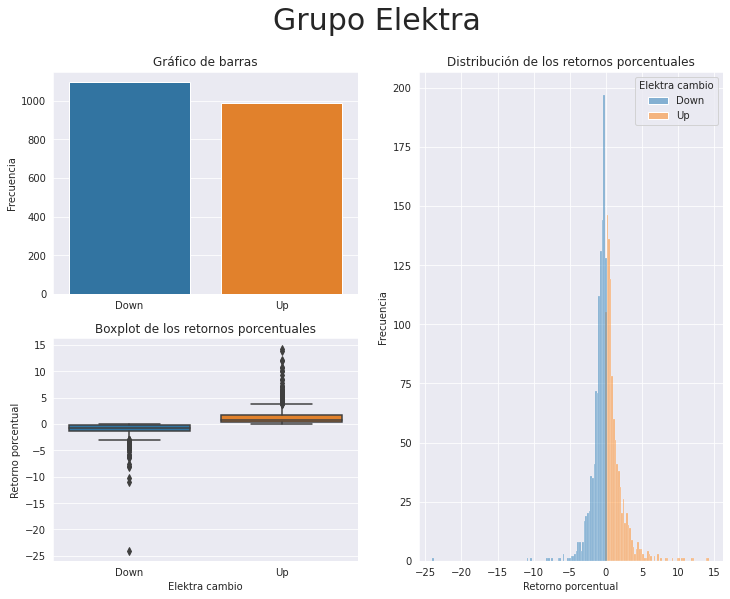

In [ ]:
aux = final.groupby('Elektra cambio')['Elektra'].count()

plt.figure(figsize=(12, 9))

plt.subplot(2, 2, 1)
sns.barplot(x = aux.index, y = aux)
plt.xlabel('')
plt.ylabel('Frecuencia')
plt.title('Gráfico de barras')

plt.subplot(2, 2, (2, 4))
sns.histplot(x = final['Elektra'], hue = final['Elektra cambio'])
plt.xlabel('Retorno porcentual')
plt.ylabel('Frecuencia')
plt.title('Distribución de los retornos porcentuales')

plt.subplot(2, 2, 3)
sns.boxplot(x = final['Elektra cambio'], y = final['Elektra'])
plt.ylabel('Retorno porcentual')
plt.title('Boxplot de los retornos porcentuales')

plt.suptitle('Grupo Elektra', fontsize = 30)

plt.show()

Aquí podemos observar algo curioso: esta es la primera, y la única, empresa cuyos periodos a la baja son mayores a los periodos a la alza, sin embargo no es demasiado esa diferencia entre categorías pues la distribución es simétrica.

### Análisis multivariable y tablas de contingencia

Hemos visto que las distribuciones de los datos generalmente son simétricas y la presencia de outliers las hace ser de colas pesadas, por lo que la distribución conjunta de estas empresas dos a dos debe presentar esta cualidad pero en 2 dimensiones, o sea la distribución conjunta de dos empresas debe acumularse en una región y presentar algunos valores fuera de dicha región. 

Veamos dichas distribuciones conjuntas, para esto hagamos una función que nos haga las gráficas bivariadas de las empresas que le demos:     

In [ ]:
def dist_biv(serie1, serie2):
    joint_kws = dict(gridsize=25)
    sns.jointplot(x = serie1, y = serie2, kind='hex', joint_kws=joint_kws)
    plt.suptitle('Distribución bivariada', y = 1.01, fontsize =15)

Veamos ahora un par de gráficas. Por ejemplo GAP y Cemex:

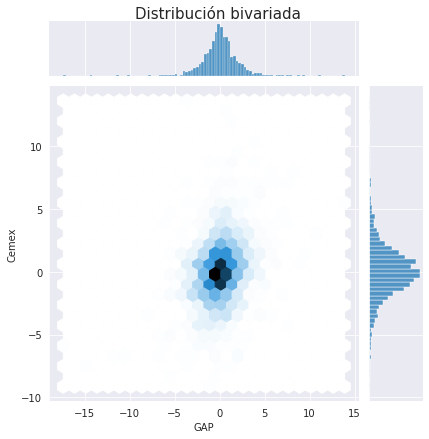

In [ ]:
dist_biv(ret_pct['GAP'], ret_pct['Cemex'])

Ahora Walmart y Corportativo Fragua:

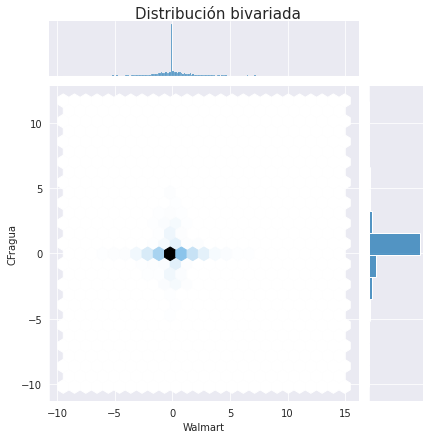

In [ ]:
dist_biv(ret_pct['Walmart'], ret_pct['CFragua'])

Ahora Corporativo Fragua y Grupo Financiero Banorte:

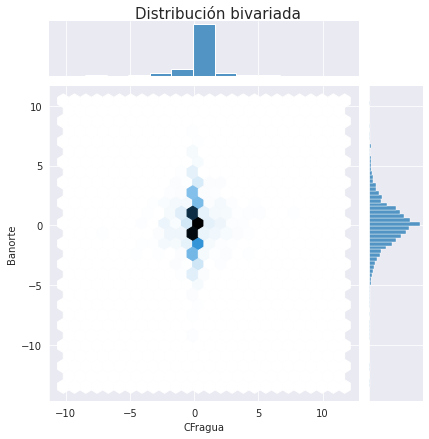

In [ ]:
dist_biv(ret_pct['CFragua'], ret_pct['Banorte'])

Podemos observar que las únicas distribuciones bivariadas cuyo comportamiento es raro son aquellas que contienen a Corporativo Fragua o a Walmart. Esto se sigue de analizar sus distribuciones univariadas pues sus histogramas presentan un valor cercano a 0 que se repite.

Algo un poco más interesante de saber y que es parte de lo que motiva el aplicar el modelo VAR es como se relacionan las categorías pues esto nos da indicios de qué tanto la subida (o bajada) de precios de una empresa está asociado a la subida (o bajada) de precios de otra empresa. Esto se puede ver usando tablas de contingencia.

Veamos un par de casos, empecemos viendo las empresas GAP y Cemex:

In [ ]:
pd.crosstab(up_down['GAP cambio'], up_down['Cemex cambio'])

Cemex cambio,Down,Up
GAP cambio,,
Down,575,425
Up,446,638


Se puede observar en la tabla de contingencia que predominan los casos donde los precios de las empresas tienden igual, o sea que en la mayoria de los casos cuando GAP pierde valor (o lo gana) también lo hace Cemex.

Veamos ahora GAP y Walmart:

In [ ]:
pd.crosstab(up_down['GAP cambio'], up_down['Walmart cambio'])

Walmart cambio,Down,Up
GAP cambio,,
Down,324,676
Up,333,751


En este caso vemos que los casos que predominan son cuando Walmart va a la alza. Sin embargo recordemos, por la grááfica de barras, que el número de casos a la alza es mucho mayor en Walmart.

Ahora veamos GAP y Corporativo Fragua:

In [ ]:
pd.crosstab(up_down['GAP cambio'], up_down['CFragua cambio'])

CFragua cambio,Down,Up
GAP cambio,,
Down,202,798
Up,189,895


Se observa un comportamiento similar al anterior y es por la misma razón: Corporativo Fragua tiene demasiados casos a la alza.

Veamos ahora GAP y Banorte:

In [ ]:
pd.crosstab(up_down['GAP cambio'], up_down['Banorte cambio'])

Banorte cambio,Down,Up
GAP cambio,,
Down,571,429
Up,413,671


También podemos ver una tabla de contingencia un poco máás grande que tome en cuenta combinaciones de empresas:

In [ ]:
pd.crosstab([up_down['GAP cambio'],up_down['Cemex cambio']], [up_down['Walmart cambio'], up_down['CFragua cambio']])

Walmart cambio          Down        Up     
CFragua cambio          Down   Up Down   Up
GAP cambio Cemex cambio                    
Down       Down           34  145   74  322
           Up             29  116   65  215
Up         Down           29  108   57  252
           Up             34  162   69  373

Claramente Walmart y Corporativo Fragua inclinan los conteos al lado de las alzas. Veamos una tabla de empresas más: 

In [ ]:
pd.crosstab([up_down['GAP cambio'], up_down['Cemex cambio'], up_down['Banorte cambio']], [up_down['AMovil cambio'], up_down['Elektra cambio']])

AMovil cambio                          Down        Up     
Elektra cambio                         Down   Up Down   Up
GAP cambio Cemex cambio Banorte cambio                    
Down       Down         Down            158  101   70   51
                        Up               70   50   40   35
           Up           Down             57   42   42   50
                        Up               50   51   63   70
Up         Down         Down             69   61   43   45
                        Up               53   63   54   58
           Up           Down             38   31   72   54
                        Up               63   56  154  170

Podemos ver que parece que las empresas avanzan en las mismas tendencias pues son las categorias a la baja y a la alza las que presentan un mayor conteo.

### Correlaciones, *pairplots* y regresiones lineales

#### Matriz de correlación
Ahora veremos si nuestros datos tienen algun tipo de correlación, esta información será útil para análisis posteriores. 

In [ ]:
corr_final = final.corr()
print(corr_final)

              GAP     Cemex   Walmart   CFragua   Banorte    AMovil   Elektra
GAP      1.000000  0.288027 -0.107758  0.059555  0.380551  0.261302  0.070488
Cemex    0.288027  1.000000 -0.089163  0.036598  0.374479  0.311834  0.084852
Walmart -0.107758 -0.089163  1.000000 -0.016443 -0.125407  0.033354  0.026991
CFragua  0.059555  0.036598 -0.016443  1.000000  0.064132  0.040187  0.015429
Banorte  0.380551  0.374479 -0.125407  0.064132  1.000000  0.297525  0.076018
AMovil   0.261302  0.311834  0.033354  0.040187  0.297525  1.000000  0.083154
Elektra  0.070488  0.084852  0.026991  0.015429  0.076018  0.083154  1.000000


Text(0.5, 1.0, 'Heatmap matriz de correlación')

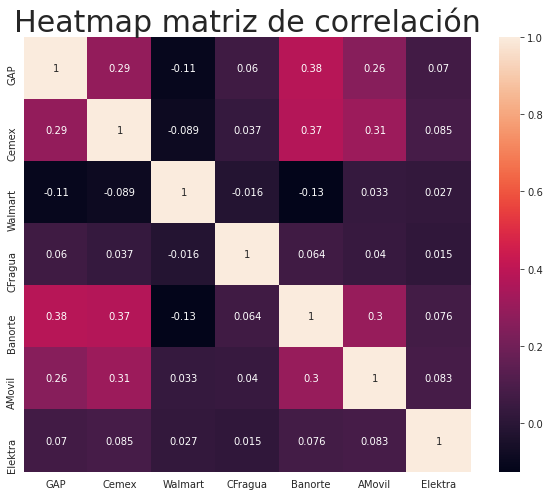

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_final, annot=True).set_title("Heatmap matriz de correlación", size=30)

Veamos ahora las gráficas de pares correspondientes a los valores de los retornos porcentuales de cada empresa:

Text(0.5, 1.01, 'Gráficas de pares')

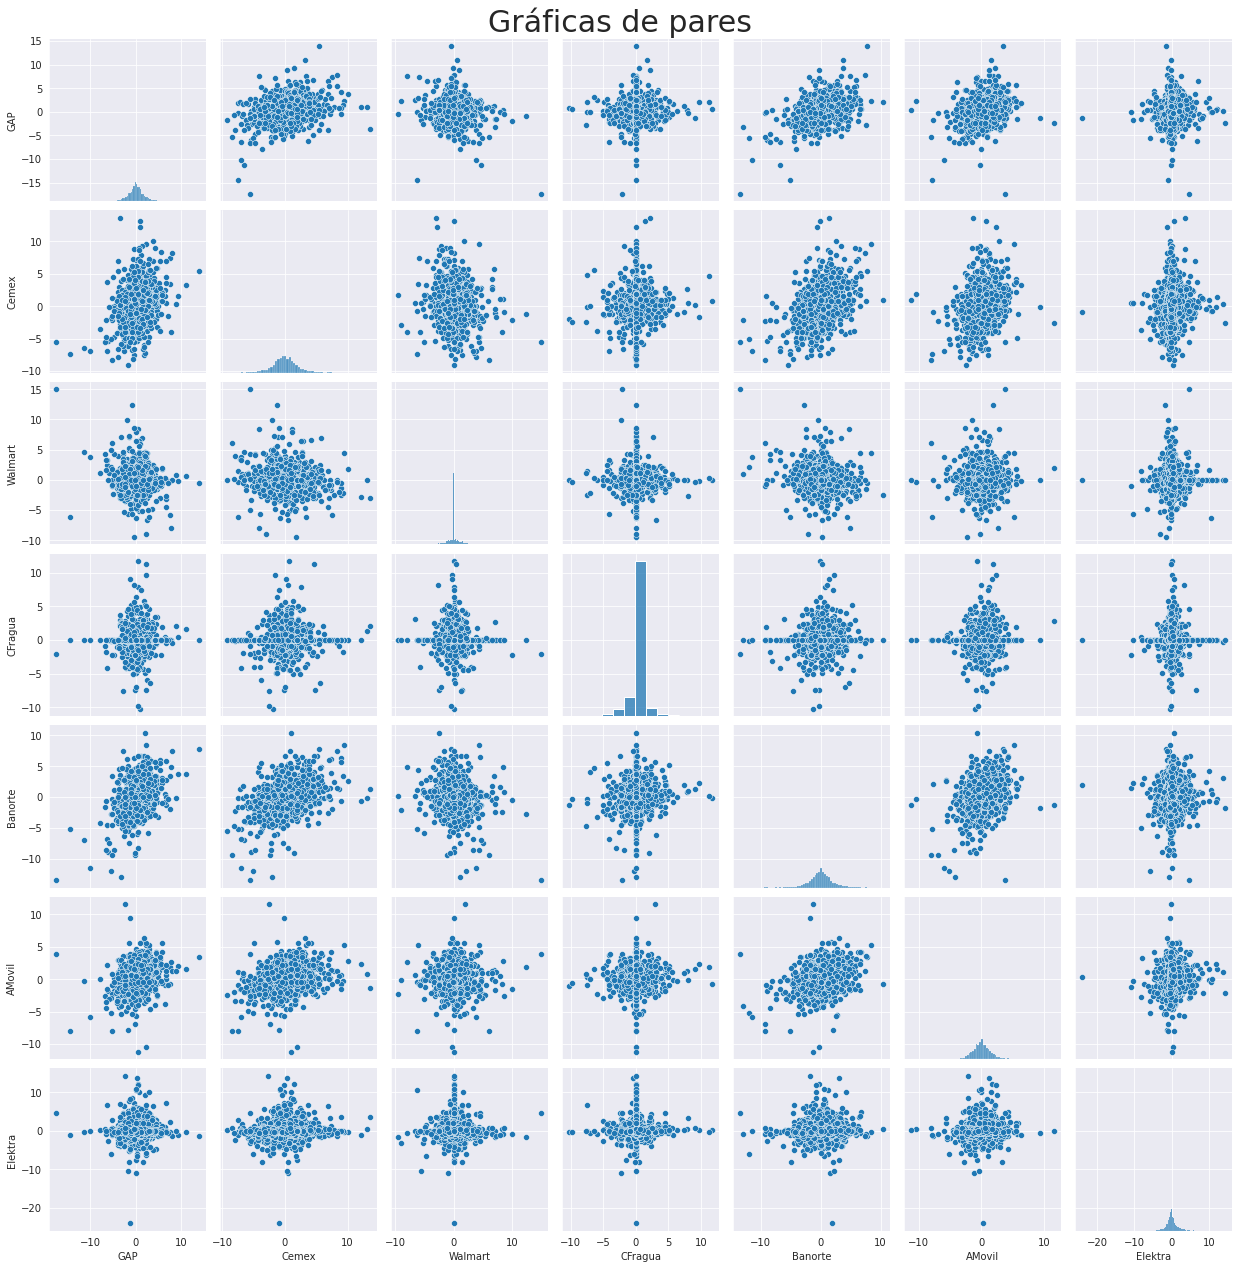

In [ ]:
sns.pairplot(data = ret_pct)
plt.suptitle('Gráficas de pares', fontsize = 30, y = 1.01)

Se puede observar que las empresas Walmart y Corporativo Fragua al tener un valor cercano a 0 que se repite demasiado, esto provoca que en el resto de las gráficas de pares se vean puntos que parecen rectas. Para el resto de las empresas los gráficos de dispersión presentan formas definidas. 
También al relizar un análisis en del pairplot con el heatmap de las correlaciones, podemos observar que los scatterplots de las empresas que presentan una mejor correlación tienen una forma mejor definida y más parecida a un recta con pendiente positva, en comparación, las parejas que presentan una correlación más cercanas a 0 son aquellas en las que la gráfica se observa una linea recta justo en la zona de 0% de retorno, un claro ejemplo de esto es Corporativo Fragua que muestra las correlaciones más cercanas a cero.  

Ahora, aunque **realizar un modelo de regresión lineal no tiene mucho sentido en estos datos ya que son datos de series de tiempo** hagamos un par de regresiones entre las variables que presentan valores altos de correlación. El gráfico de correlaciones nos dice que las empresas GAP y Banorte tienen alta correlación, por esta razón haremos una regresión lineal entre estas variables. Empecemos creando los conjunto de entrenamiento y prueba:  

In [ ]:
X = ret_pct['GAP'].values.reshape(-1, 1)
y = ret_pct['Banorte']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

Ya creados los conjuntos podemos hacer nuestra regresión:

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Ahora hagamos la predicción con el conjunto de test y además obtengamos los valores de los coeficientes $\beta$ de la regresión:

In [ ]:
y_pred = lm.predict(X_train)
y_pred_test = lm.predict(X_test)
beta_0 = lm.intercept_
beta_1 = lm.coef_[0]
r2 = lm.score(X_train, y_train)
print(f'Intercepto = {beta_0.round(3)}\nCoeficiente = {beta_1.round(3)}\nR2 = {r2.round(3)}')

Intercepto = 0.021
Coeficiente = 0.432
R2 = 0.164


El coeficiente $R^2$ no es muy bueno. Veamos una gráfica de la implementación de este modelo: 

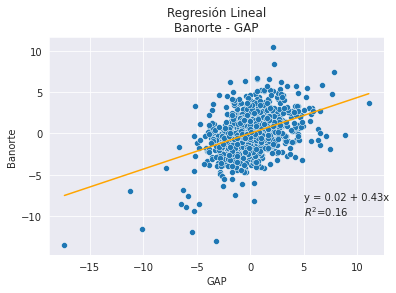

In [ ]:
sns.scatterplot(x = X_train.reshape(len(X_train),), y = y_train)
sns.lineplot(x = X_train.reshape(len(X_train),), y = y_pred, color = 'orange')
#sns.scatterplot(x = X_test.reshape(len(X_test),), y = y_test, color = 'green')
plt.text(5, -10, f'y = {beta_0.round(2)} + {beta_1.round(2)}x\n$R^2$={r2.round(2)}')
plt.xlabel('GAP')
plt.title('Regresión Lineal\nBanorte - GAP')
plt.show()

Hagamos otro ejemplo, pero ahora seleccionemos a las empresas América Móvil y Cemex. Nuevamente seleccionamos las variables a usar y dividimos los conjunto en entrenamiento y prueba: 

In [ ]:
X = ret_pct['AMovil'].values.reshape(-1, 1)
y = ret_pct['Cemex']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

Ya creados los conjuntos de entrenamiento y prueba ajustamos una regresión lineal a los datos:

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Hagamos las predicciones y veamos los coeficientes $\beta$ y el valor de $R^2$:

In [ ]:
y_pred = lm.predict(X_train)
y_pred_test = lm.predict(X_test)
beta_0 = lm.intercept_
beta_1 = lm.coef_[0]
r2 = lm.score(X_train, y_train)
print(f'Intercepto = {beta_0.round(3)}\nCoeficiente = {beta_1.round(3)}\nR2 = {r2.round(3)}')

Intercepto = 0.023
Coeficiente = 0.441
R2 = 0.094


El modelo es bastante malo. Veamos esto en las gráficas:

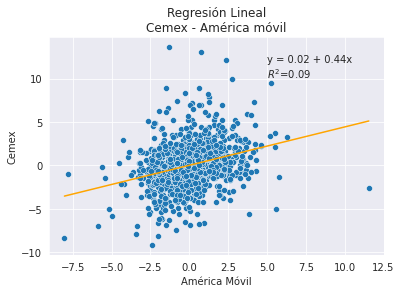

In [ ]:
sns.scatterplot(x = X_train.reshape(len(X_train),), y = y_train)
sns.lineplot(x = X_train.reshape(len(X_train),), y = y_pred, color = 'orange')
plt.text(5, 10, f'y = {beta_0.round(2)} + {beta_1.round(2)}x\n$R^2$={r2.round(2)}')
plt.xlabel('América Móvil')
plt.title('Regresión Lineal\nCemex - América móvil')
plt.show()

Estos ejemplos nos ayudan a ver la razón por la que un modelo de regresión lineal no es adecuado al momento de estudiar series de tiempo.

### *Bootstrap*, regresión lineal múltiple y validación cruzada

Podemos aplicar la técnica de *bootstrap* para poder obtener algunos intervalos de confianza de los estadísticos de cada una de las empresas. En este caso calcularemos las distribuciones de los estadísticos:
* Media
* Desviación estándar

Para esto recordemos que el *bootstrap* consiste en tomar submuestras aleatorias con reemplazo de la muestra original. En este caso tomaremos unas 10 mil observaciones de cada estadístico.

In [ ]:
med_GAP = pd.Series([ret_pct['GAP'].sample(frac = 1, replace = True).mean() for i in range(10_000)])
sd_GAP = pd.Series([ret_pct['GAP'].sample(frac = 1, replace = True).std() for i in range(10_000)])

med_Cemex  = pd.Series([ret_pct['Cemex'].sample(frac = 1, replace = True).mean() for i in range(10_000)])
sd_Cemex  = pd.Series([ret_pct['Cemex'].sample(frac = 1, replace = True).std() for i in range(10_000)])

med_Walmart = pd.Series([ret_pct['Walmart'].sample(frac = 1, replace = True).mean() for i in range(10_000)])
sd_Walmart = pd.Series([ret_pct['Walmart'].sample(frac = 1, replace = True).std() for i in range(10_000)])

med_CFragua = pd.Series([ret_pct['CFragua'].sample(frac = 1, replace = True).mean() for i in range(10_000)])
sd_CFragua = pd.Series([ret_pct['CFragua'].sample(frac = 1, replace = True).std() for i in range(10_000)])

med_Banorte = pd.Series([ret_pct['Banorte'].sample(frac = 1, replace = True).mean() for i in range(10_000)])
sd_Banorte = pd.Series([ret_pct['Banorte'].sample(frac = 1, replace = True).std() for i in range(10_000)])

med_AMovil = pd.Series([ret_pct['AMovil'].sample(frac = 1, replace = True).mean() for i in range(10_000)])
sd_AMovil = pd.Series([ret_pct['AMovil'].sample(frac = 1, replace = True).std() for i in range(10_000)])

med_Elektra = pd.Series([ret_pct['Elektra'].sample(frac = 1, replace = True).mean() for i in range(10_000)])
sd_Elektra = pd.Series([ret_pct['Elektra'].sample(frac = 1, replace = True).std() for i in range(10_000)])

Veamos los histogramas de estas distribuciones para GAP:




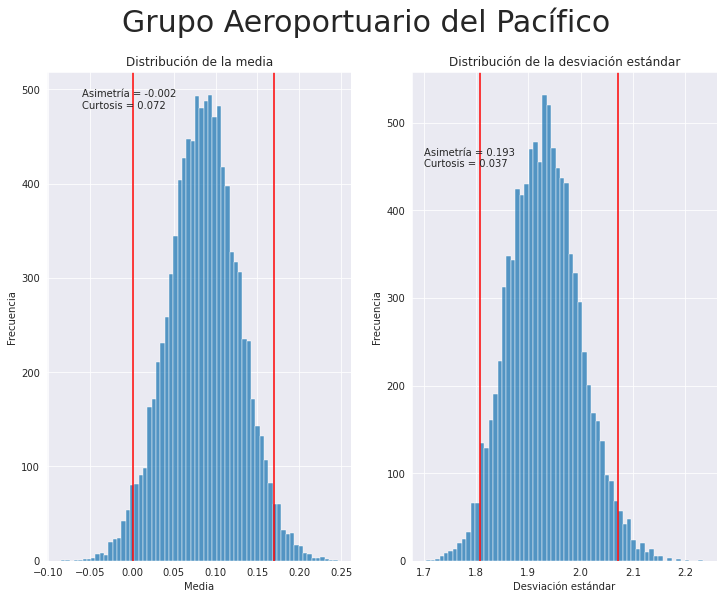

In [ ]:
plt.figure(figsize=(12, 9))

plt.subplot(121)
sns.histplot(med_GAP)
plt.title('Distribución de la media')
plt.text(-0.06, 480, f'Asimetría = {med_GAP.skew().round(3)}\nCurtosis = {med_GAP.kurtosis().round(3)}')
plt.xlabel('Media')
plt.ylabel('Frecuencia')
plt.axvline(x = med_GAP.quantile(0.025), color = 'red')
plt.axvline(x = med_GAP.quantile(0.975), color = 'red')

plt.subplot(122)
sns.histplot(sd_GAP)
plt.title('Distribución de la desviación estándar')
plt.text(1.7, 450, f'Asimetría = {sd_GAP.skew().round(3)}\nCurtosis = {sd_GAP.kurtosis().round(3)}')
plt.xlabel('Desviación estándar')
plt.ylabel('Frecuencia')
plt.axvline(x = sd_GAP.quantile(0.025), color = 'red')
plt.axvline(x = sd_GAP.quantile(0.975), color = 'red')


plt.suptitle('Grupo Aeroportuario del Pacífico ', fontsize = 30)
plt.show()

Como es de esperarse se tiene una distribución casi normal pues sus valores de asimetría y curtosis son casi nulos.

Ahora veamso las distribiones de ambos estadísticos pero para la empresa Cemex:

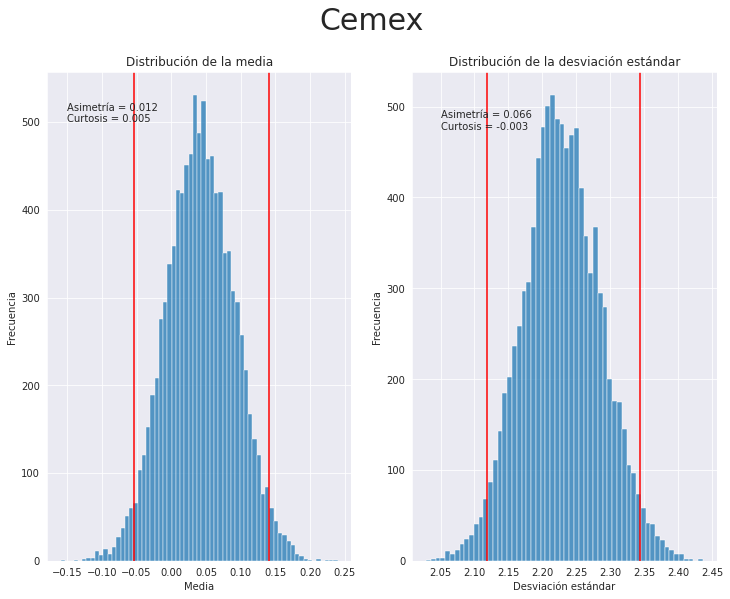

In [ ]:
plt.figure(figsize=(12, 9))

plt.subplot(121)
sns.histplot(med_Cemex)
plt.title('Distribución de la media')
plt.text(-0.15, 500, f'Asimetría = {med_Cemex.skew().round(3)}\nCurtosis = {med_Cemex.kurtosis().round(3)}')
plt.xlabel('Media')
plt.ylabel('Frecuencia')
plt.axvline(x = med_Cemex.quantile(0.025), color = 'red')
plt.axvline(x = med_Cemex.quantile(0.975), color = 'red')

plt.subplot(122)
sns.histplot(sd_Cemex)
plt.title('Distribución de la desviación estándar')
plt.text(2.05, 475, f'Asimetría = {sd_Cemex.skew().round(3)}\nCurtosis = {sd_Cemex.kurtosis().round(3)}')
plt.xlabel('Desviación estándar')
plt.ylabel('Frecuencia')
plt.axvline(x = sd_Cemex.quantile(0.025), color = 'red')
plt.axvline(x = sd_Cemex.quantile(0.975), color = 'red')

plt.suptitle('Cemex', fontsize = 30)
plt.show()

De igual forma podemos ver que se asemeja mucho a una distribucion normal por sus estadisticos cercanos a 0


Veamos las distribuciones para Walmart:

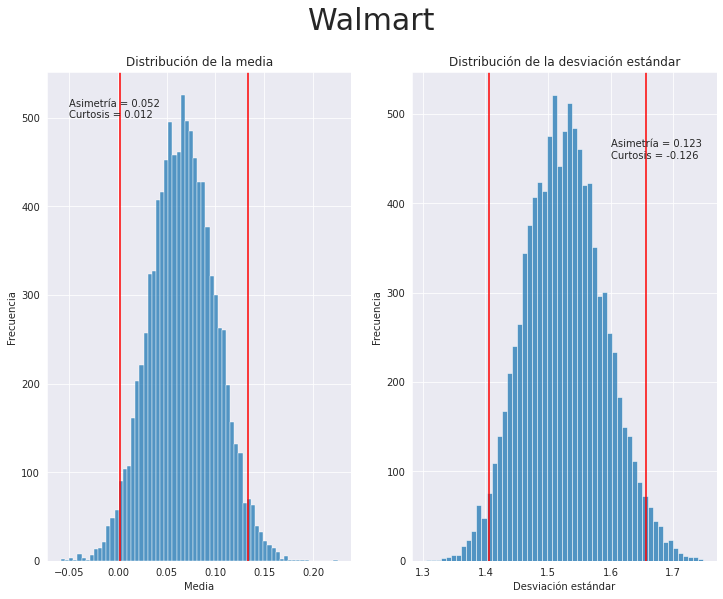

In [ ]:
plt.figure(figsize=(12, 9))

plt.subplot(121)
sns.histplot(med_Walmart)
plt.title('Distribución de la media')
plt.text(-0.05, 500, f'Asimetría = {med_Walmart.skew().round(3)}\nCurtosis = {med_Walmart.kurtosis().round(3)}')
plt.xlabel('Media')
plt.ylabel('Frecuencia')
plt.axvline(x = med_Walmart.quantile(0.025), color = 'red')
plt.axvline(x = med_Walmart.quantile(0.975), color = 'red')

plt.subplot(122)
sns.histplot(sd_Walmart)
plt.title('Distribución de la desviación estándar')
plt.text(1.6, 450, f'Asimetría = {sd_Walmart.skew().round(3)}\nCurtosis = {sd_Walmart.kurtosis().round(3)}')
plt.xlabel('Desviación estándar')
plt.ylabel('Frecuencia')
plt.axvline(x = sd_Walmart.quantile(0.025), color = 'red')
plt.axvline(x = sd_Walmart.quantile(0.975), color = 'red')

plt.suptitle('Walmart', fontsize = 30)
plt.show()

Tenemos casi una distribución normal. Veamos ahora a la empresa Corporativo Fragua:

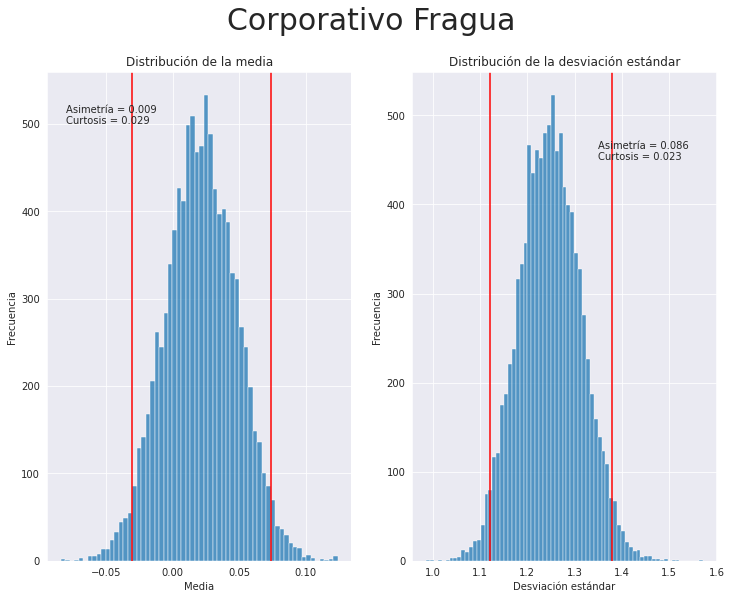

In [ ]:
plt.figure(figsize=(12, 9))

plt.subplot(121)
sns.histplot(med_CFragua)
plt.title('Distribución de la media')
plt.text(-0.08, 500, f'Asimetría = {med_CFragua.skew().round(3)}\nCurtosis = {med_CFragua.kurtosis().round(3)}')
plt.xlabel('Media')
plt.ylabel('Frecuencia')
plt.axvline(x = med_CFragua.quantile(0.025), color = 'red')
plt.axvline(x = med_CFragua.quantile(0.975), color = 'red')


plt.subplot(122)
sns.histplot(sd_CFragua)
plt.title('Distribución de la desviación estándar')
plt.text(1.35, 450, f'Asimetría = {sd_CFragua.skew().round(3)}\nCurtosis = {sd_CFragua.kurtosis().round(3)}')
plt.xlabel('Desviación estándar')
plt.ylabel('Frecuencia')
plt.axvline(x = sd_CFragua.quantile(0.025), color = 'red')
plt.axvline(x = sd_CFragua.quantile(0.975), color = 'red')


plt.suptitle('Corporativo Fragua', fontsize = 30)
plt.show()

Nuevamente obtenemos una distribución casi normal. La siguiente empresa es Grupo Financiero Banorte:

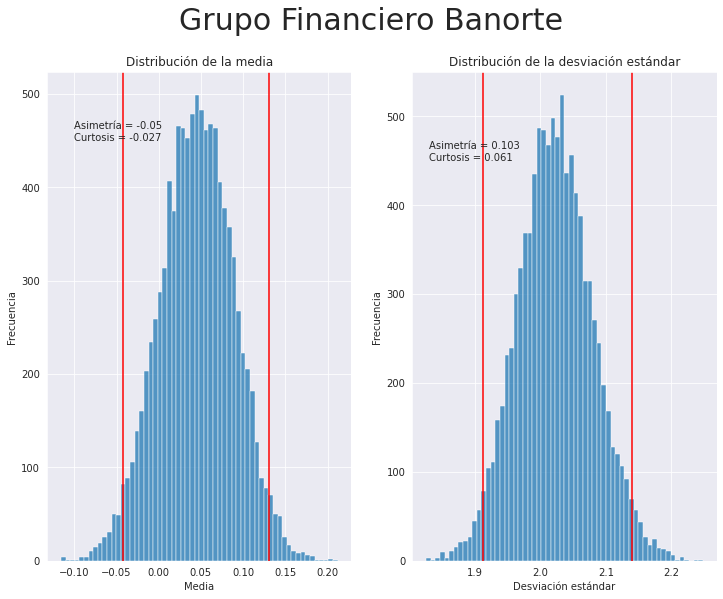

In [ ]:
plt.figure(figsize=(12, 9))

plt.subplot(121)
sns.histplot(med_Banorte)
plt.title('Distribución de la media')
plt.text(-0.1, 450, f'Asimetría = {med_Banorte.skew().round(3)}\nCurtosis = {med_Banorte.kurtosis().round(3)}')
plt.xlabel('Media')
plt.ylabel('Frecuencia')
plt.axvline(x = med_Banorte.quantile(0.025), color = 'red')
plt.axvline(x = med_Banorte.quantile(0.975), color = 'red')


plt.subplot(122)
sns.histplot(sd_Banorte)
plt.title('Distribución de la desviación estándar')
plt.text(1.83, 450, f'Asimetría = {sd_Banorte.skew().round(3)}\nCurtosis = {sd_Banorte.kurtosis().round(3)}')
plt.xlabel('Desviación estándar')
plt.ylabel('Frecuencia')
plt.axvline(x = sd_Banorte.quantile(0.025), color = 'red')
plt.axvline(x = sd_Banorte.quantile(0.975), color = 'red')


plt.suptitle('Grupo Financiero Banorte', fontsize = 30)
plt.show()

La siguiente empresa es América Móvil, veamos sus distribuciones:

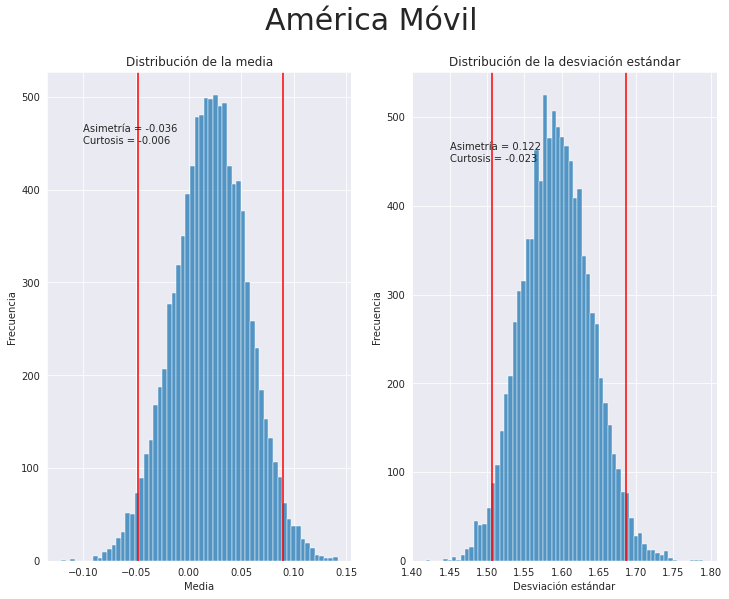

In [ ]:
plt.figure(figsize=(12, 9))

plt.subplot(121)
sns.histplot(med_AMovil)
plt.title('Distribución de la media')
plt.text(-0.1, 450, f'Asimetría = {med_AMovil.skew().round(3)}\nCurtosis = {med_AMovil.kurtosis().round(3)}')
plt.xlabel('Media')
plt.ylabel('Frecuencia')
plt.axvline(x = med_AMovil.quantile(0.025), color = 'red')
plt.axvline(x = med_AMovil.quantile(0.975), color = 'red')


plt.subplot(122)
sns.histplot(sd_AMovil)
plt.title('Distribución de la desviación estándar')
plt.text(1.45, 450, f'Asimetría = {sd_AMovil.skew().round(3)}\nCurtosis = {sd_AMovil.kurtosis().round(3)}')
plt.xlabel('Desviación estándar')
plt.ylabel('Frecuencia')
plt.axvline(x = sd_AMovil.quantile(0.025), color = 'red')
plt.axvline(x = sd_AMovil.quantile(0.975), color = 'red')


plt.suptitle('América Móvil', fontsize = 30)
plt.show()

Finalmente veamos las distribuciones de los estadísticos de Grupo Elektra:

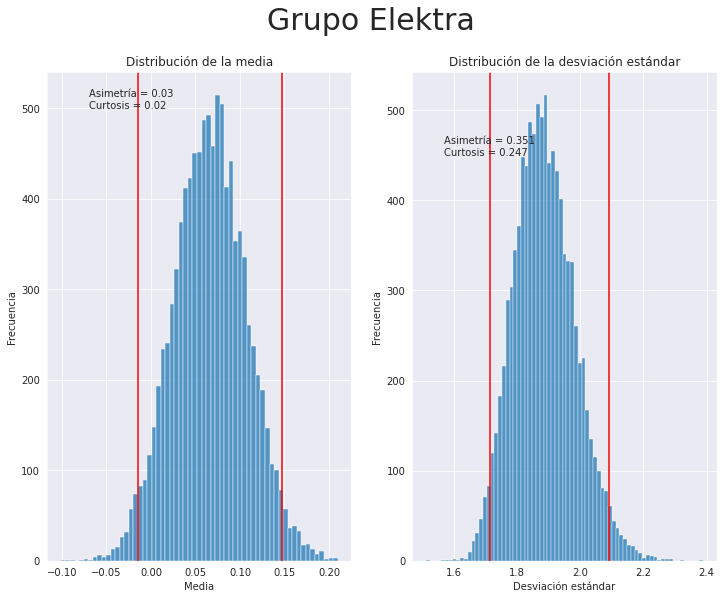

In [ ]:
plt.figure(figsize=(12, 9))

plt.subplot(121)
sns.histplot(med_Elektra)
plt.title('Distribución de la media')
plt.text(-0.07, 500, f'Asimetría = {med_Elektra.skew().round(3)}\nCurtosis = {med_Elektra.kurtosis().round(3)}')
plt.xlabel('Media')
plt.ylabel('Frecuencia')
plt.axvline(x = med_Elektra.quantile(0.025), color = 'red')
plt.axvline(x = med_Elektra.quantile(0.975), color = 'red')


plt.subplot(122)
sns.histplot(sd_Elektra)
plt.title('Distribución de la desviación estándar')
plt.text(1.57, 450, f'Asimetría = {sd_Elektra.skew().round(3)}\nCurtosis = {sd_Elektra.kurtosis().round(3)}')
plt.xlabel('Desviación estándar')
plt.ylabel('Frecuencia')
plt.axvline(x = sd_Elektra.quantile(0.025), color = 'red')
plt.axvline(x = sd_Elektra.quantile(0.975), color = 'red')


plt.suptitle('Grupo Elektra', fontsize = 30)
plt.show()

Se pueden observar en todas las distribuciones que los estadísticos tienden a una distribución normal.

### Regresión lineal múltiple y validación cruzada

Realicemos una regresión lineal múltiple para explicar le valor de los retornos porcentuales de la empresa Cemex en función del resto de empresas. Como se mencionó antes, los modelos de regresión lineal no son adecuados cuando se tienen datos indexados por tiempo y que además poseen una estructura estacionaria, aún así veamos un modelo de regresión lineal. Para validar el modelo usaremos validación cruzada con 5 divisiones de la base. Empecemos definiendo los predictores y la variable respuesta:

In [ ]:
features = ['GAP', 'Walmart', 'CFragua', 'Banorte', 'AMovil', 'Elektra']
X = ret_pct[features]
y = ret_pct['Cemex']

Ya definidas las variables $X$ y $y$ definamos el modelos y apliquemos validación cruzada para obtener los valores del coeficiente $R^2$:

In [ ]:
lm = LinearRegression()
r2 = cross_validate(lm, X, y, scoring='r2', cv = 5)
r2

{'fit_time': array([0.01367021, 0.00561857, 0.00307417, 0.00299454, 0.00303197]),
 'score_time': array([0.00273561, 0.00157189, 0.0015285 , 0.0015161 , 0.0015223 ]),
 'test_score': array([0.01703408, 0.18419883, 0.10611792, 0.22146774, 0.24354974])}

Finalmente obtengamos el valor promedio de los coeficientes de $R^2$ obtenidos usando CV.

In [ ]:
r2['test_score'].mean().round(3)

0.154

Podemos observar nuevamente que un modelo lineal no es el adecuado para este tipo de datos temporales.

### Visualización de datos avanzada




#### Treemaps

Para esta sección haremos una visualización de la cantidad de retornos que fueron Down y Up, esto ya lo habíamos visto en la sección de Visualización de datos categóricos, solo que ahora utilizamos los treemaps, que nos permité tener una visión un poco más completa de todas las empresas con las que estamos trabajando.

In [ ]:
nueva = up_down
nueva['v'] = 1
n = pd.DataFrame(columns=["emp","tipo","count"])
for column in up_down.loc[:,up_down.columns != 'v'].columns.values:
    m = nueva.groupby(column).count()[['v']]
    for ind in m.index.values:
      n = n.append([{'emp':column,'tipo':ind,'count':m['v'][ind]}], ignore_index=True)

In [ ]:
fig = px.treemap(n, values='count', path=['emp','tipo'])
fig.show()

Con este gráfico podemos observar que Corporativo Fragua y Walmart son las empresa que cuenta con mas retornos porcentuales positivos.  

### Regresión logística

Al tener variables categóricas y variables númericas podemos intentar explicar algunas de las variables categóricas usando las variables numéricas. Como ejemplo podemos intentar explicar la categoría `Walmart cambio` en función de los retornos porcentuales del resto de empresas. Para esto empecemos convirtiendo las categorías `Up` y `Down` a 1 y 0, respectivamente y definiendo los conjuntos $X$ y $y$:

In [ ]:
features = ['GAP', 'Cemex', 'CFragua', 'Banorte', 'AMovil', 'Elektra']
X = final[features]
y = final['Walmart cambio'].apply(lambda x: 1 if x == 'Up' else 0)

Ya definidas las variables $X$ y $y$ seleccionemos los conjuntos de entrenamiento y de prueba:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

Ya con esto podemos realizar nuestro modelo de regresión logística:

In [ ]:
log_reg = LogisticRegression(max_iter=10_000)

Ajustemos nuestros datos de entrenamiento al modelo:

In [ ]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Calculamos las predicciones para el conjunto de prueba:

In [ ]:
y_pred = log_reg.predict(X_test)

Obtengamos el score del modelo:

In [ ]:
log_reg.score(X_test, y_test)

0.6884984025559105

Al parecer se tiene un modelo medianamente bueno pues supera el valor de 0.5. Veamos la matriz de confusión para los datos de prueba:

In [ ]:
confusion_matrix(y_test, y_pred)

array([[  1, 193],
       [  2, 430]])

Se puede observar que el modelo es bastante bueno para predecir subidas precio, sin embargo falla demasiado al momento de predecir bajadas de precio, o sea se tiene un valor muy alto de precisión y uno muy bajo de sensibilidad.

### Implementación del modelo VAR

Una vez recorrido todo este camino es momento de implementar el modelo de vectores autoregresivos. Hemos visto en la parte de regresiones lineales como este tipo de algoritmos no son óptimos a la hora de intentar predecir valores de nuestros datos y esto se debe principalmente a dos razones:

* Los datos provienen de una serie de tiempo, por lo que el orden de los datos afecta bastante. El modelo de regresión lineal NO tiene en cuenta esto.
* Los datos son altamente no lineales (por desgracia).

Un comentario adicional a estos dos es que las predicciones en series de tiempo hacen uso de los valores que tienen las series en tiempos anteriores al actual (de ahí el nombre de autoregresivos); esta es otra razón por la cual los modelos de regresión lineal no sirven del todo.

Una vez explicado esto empecemos a implementar el modelo VAR. Como se mencionó bastantes líneas arriba, uno de los principales requisitos para implementar un modelo VAR es que las series requieren ser estacionarias, dicho requisito se tiene pues se usó la prueba de *Dickey-Fuller* aumentada para probar estacionariedad.

Implementemos pues el modelo:

In [ ]:
mod_VAR = VAR(ret_pct)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Análogo a como pasaba en regresión lineal el modelo debe de ajustarse, sin embargo al ajustarse se le debe de dar el número de retrasos en cada variable que serán usados para explicar el precio actual de cada empresa. Esta tarea no es sencilla y existen distintos métodos para elegir el *lag* adecuado, sin embargo, por comodidad, usaremos los criterios de información estadística AIC y BIC para elegir al mejor modelo. Bajo estos criterios un modelo es mejor que otro si sus valores de AIC y BIC son menores.

Veamos los valores de AIC y BIC para 1 retraso:

In [ ]:
mod_VAR.fit(1).summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 27, Apr, 2021
Time:                     02:12:33
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    7.38831
Nobs:                     2083.00    HQIC:                   7.29221
Log likelihood:          -28170.5    FPE:                    1389.41
AIC:                      7.23664    Det(Omega_mle):         1352.63
--------------------------------------------------------------------
Results for equation GAP
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.085244         0.042389            2.011           0.044
L1.GAP             0.036274         0.024306            1.492           0.136
L1.Cemex           0.030048         0.021243            1.414           0.

¡Demasiada información!

Expliquemos que estamos viendo paso a paso:
* La primera parte consiste en estadísticas del modelo, por ejemplo la log-verosimilitud, el AIC, el BIC y otros criterios de información además de características de nuestras series de tiempo.
* La segunda parte es la más importante pues nos dice como es que el valor actual del precio de una empresa depende del precio del resto de empresas y sus respectivos retrasos (en este caso un retraso). Ahí aparecen unos t-estadísticos que sirven para probar la significancia estadística de los coeficientes. Esto es similar a regresión lineal cuando se hace la prueba de hipótesis:
$$H_0: \beta_i=0$$
$$H_1: \beta_i\neq 0$$

Veamos ahora los valores que arroja un modelo con dos retrasos:

In [ ]:
mod_VAR.fit(2).summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 27, Apr, 2021
Time:                     02:34:54
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    7.52250
Nobs:                     2082.00    HQIC:                   7.34225
Log likelihood:          -28109.4    FPE:                    1391.32
AIC:                      7.23801    Det(Omega_mle):         1323.13
--------------------------------------------------------------------
Results for equation GAP
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.082541         0.042471            1.943           0.052
L1.GAP             0.035505         0.024342            1.459           0.145
L1.Cemex           0.027184         0.021237            1.280           0.

Los criterios de información están demasiado cerca, veamos a 3 lags:

In [ ]:
mod_VAR.fit(3).summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 27, Apr, 2021
Time:                     02:40:07
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    7.67211
Nobs:                     2081.00    HQIC:                   7.40765
Log likelihood:          -28064.2    FPE:                    1414.74
AIC:                      7.25469    Det(Omega_mle):         1314.33
--------------------------------------------------------------------
Results for equation GAP
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.082401         0.042640            1.933           0.053
L1.GAP             0.035052         0.024434            1.435           0.151
L1.Cemex           0.027985         0.021270            1.316           0.

Después de ver los valores de los criterios de información podemos concluir que **el mejor modelo VAR es el VAR(1)**.

Veamos las gráficas de los modelos:

In [ ]:
res = mod_VAR.fit(1)

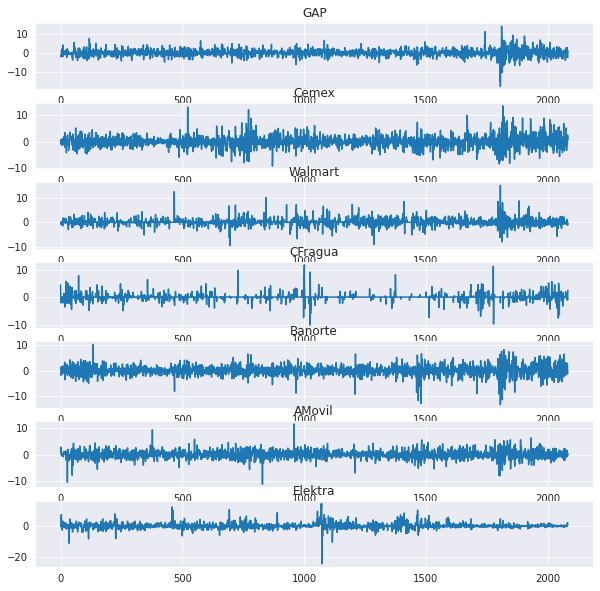

In [ ]:
res.plot();

Veamos los correlogramas:

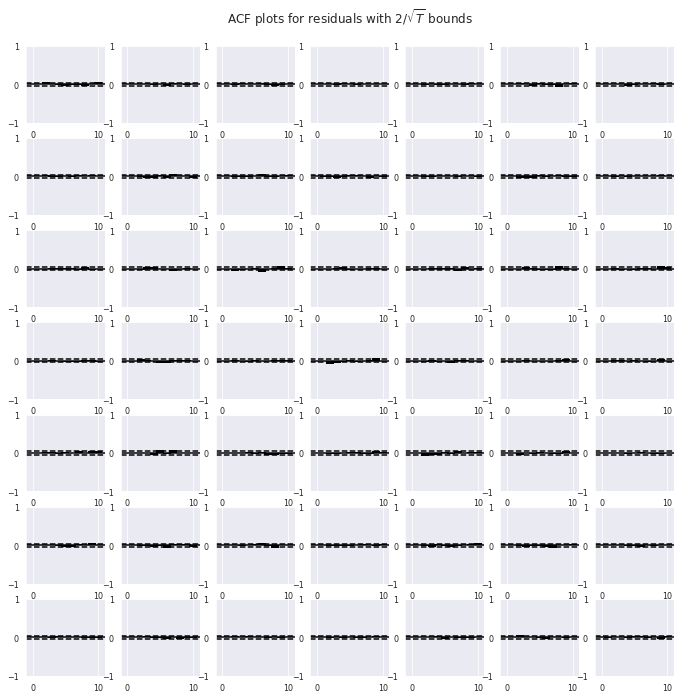

In [ ]:
res.plot_acorr();

Se puede observar que los correlogramas no muestran valores fuera de los intervalos de confianza, por lo que se cumple que los residuales del modelo son ruido blanco.

Finalmente hagamos una predicción a 7 días y veamos las gráficas:

In [ ]:
preds = pd.DataFrame(res.forecast(ret_pct.values[-1:], 7), columns=['GAP', 'Cemex', 'Walmart', 'CFragua', 'Banorte', 'AMovil', 'Elektra'], index=[fin + np.timedelta64(i,'D') for i in range(1,8)])
preds

,GAP,Cemex,Walmart,CFragua,Banorte,AMovil,Elektra
2021-04-27,-0.071474,-0.231186,0.277404,-0.135864,-0.054672,-0.021629,0.170338
2021-04-28,0.065744,0.035508,0.078416,0.033339,0.023845,0.025528,0.085654
2021-04-29,0.084373,0.040022,0.068429,0.018678,0.043784,0.020926,0.069985
2021-04-30,0.087081,0.042165,0.067170,0.019563,0.045504,0.021187,0.067337
2021-05-01,0.087372,0.042309,0.066927,0.019435,0.045685,0.021121,0.066812
2021-05-02,0.087415,0.042338,0.066914,0.019434,0.045714,0.021116,0.066713
2021-05-03,0.087421,0.042341,0.066910,0.019431,0.045715,0.021114,0.066693


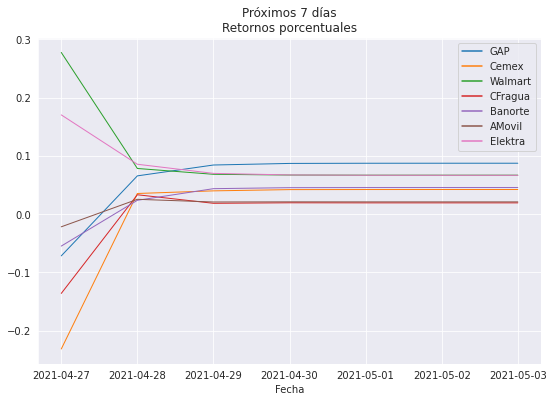

In [ ]:
fig = plt.figure(figsize=(9,6))
sns.lineplot(data=preds, dashes=False, lw = 1)
plt.title('Próximos 7 días\nRetornos porcentuales')
plt.xlabel('Fecha')
plt.legend(loc = 'upper right')
plt.show()